# 1.  Dataset Preparation and Preprocessing

**import needed libraries**

In [8]:
!pip install ultralytics
!pip install deep-sort-realtime
!pip install lap
!pip install motmetrics

import warnings
warnings.filterwarnings('ignore')

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision.transforms.functional as F
from PIL import Image
import numpy as np
import configparser
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import albumentations as A
from albumentations.pytorch import ToTensorV2
from ultralytics import YOLO
from tqdm import tqdm
import cv2
import shutil
from torch.utils.data import Subset
import yaml
import pandas as pd
import time
from deep_sort_realtime.deepsort_tracker import DeepSort
from IPython.display import display, HTML
import warnings
import sys
import base64
from sklearn.metrics import precision_score, recall_score, f1_score
import motmetrics as mm
from glob import glob

### Define SportsMOTDataset class to extract data.

In [2]:
class SportsMOTDataset(Dataset):
    def __init__(self, data_root, splits_txt_dir, split, transform=None):
        """
        Args:
            data_root (str): Path to the dataset root directory.
            splits_txt_dir (str): Path to the directory containing split text files.
            split (str): One of 'train', 'val', or 'test'.
            transform (callable, optional): Transformations to apply to the samples.
        """
        self.data_root = os.path.join(data_root, split)
        self.splits_txt_dir = splits_txt_dir
        self.split = split
        self.transform = transform

        # Retrieve the list of video names based on the split
        self.video_names = self.parse_split_file(split)

        self.image_paths = []
        self.annotation_paths = []

        for video in self.video_names:
            video_path = os.path.join(self.data_root, video)
            img_dir = os.path.join(video_path, "img1")
            gt_dir = os.path.join(video_path, "gt")
            gt_file = os.path.join(gt_dir, "gt.txt")

            if not os.path.exists(img_dir):
                print(f"Image directory {img_dir} does not exist. Skipping video {video}.")
                continue

            # Supported image formats
            images = sorted([img for img in os.listdir(img_dir) if img.lower().endswith(('.jpg', '.jpeg', '.png'))])
            self.image_paths.extend([os.path.join(img_dir, img) for img in images])

            if self.split in ['train', 'val']:
                if os.path.exists(gt_file):
                    self.annotation_paths.extend([gt_file] * len(images))
                else:
                    print(f"Annotation file {gt_file} does not exist for video {video}.")
                    self.annotation_paths.extend([None] * len(images))
            else:
                # For the Test set, annotations might not be available
                self.annotation_paths.extend([None] * len(images))

        print(f"{split.capitalize()} split: {len(self.image_paths)} images found.")

    def parse_split_file(self, split_name):
        """
        Parses the split text file to retrieve video names.

        Args:
            split_name (str): Name of the split ('train', 'val', or 'test').

        Returns:
            list: List of video names.
        """
        split_file = os.path.join(self.splits_txt_dir, f"{split_name}.txt")
        if not os.path.exists(split_file):
            raise FileNotFoundError(f"Split file {split_file} does not exist.")

        with open(split_file, 'r') as f:
            video_names = [line.strip() for line in f.readlines() if line.strip()]
        return video_names

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Retrieves the image and its corresponding annotations.

        Args:
            idx (int): Index of the sample.

        Returns:
            tuple: (image, targets) where targets is a dict containing 'boxes', 'labels', and 'ids'.
        """
        # Load image
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black image with no annotations if image loading fails
            image = Image.new("RGB", (256, 256), (0, 0, 0))  # Adjust size as needed
            boxes = []
            labels = []
            ids = []
        else:
            # Load annotations if available
            ann_path = self.annotation_paths[idx]
            if ann_path:
                annotations = self._load_annotations(ann_path, idx)
                if annotations.size > 0:
                    # Extract bounding boxes (x, y, w, h), labels (cls), and ids
                    boxes = annotations[:, 2:6].tolist()  # [x, y, w, h]
                    labels = annotations[:, 7].astype(int).tolist()  # 'cls' column
                    ids = annotations[:, 1].astype(int).tolist()     # 'id' column

                    # Convert bounding boxes to (x_min, y_min, x_max, y_max)
                    boxes = [[x, y, x + w, y + h] for (x, y, w, h) in boxes]
                else:
                    boxes = []
                    labels = []
                    ids = []
            else:
                boxes = []
                labels = []
                ids = []

        # Convert image to numpy array
        image = np.array(image)

        # Apply transformations if any
        if self.transform:
            # Albumentations expects labels separate from boxes
            transformed = self.transform(image=image, bboxes=boxes, labels=labels)
            image = transformed['image']
            boxes = transformed['bboxes']
            labels = transformed['labels']
            # Note: If transformations like cropping or rotating are applied,
            # 'boxes' are already transformed accordingly

        # Convert bounding boxes and labels to tensors
        if len(boxes) > 0:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)
            ids = torch.tensor(ids, dtype=torch.int64)
            targets = {'boxes': boxes, 'labels': labels, 'ids': ids}
        else:
            # Return empty tensors if no annotations are present
            targets = {
                'boxes': torch.empty((0, 4), dtype=torch.float32),
                'labels': torch.empty((0,), dtype=torch.int64),
                'ids': torch.empty((0,), dtype=torch.int64)
            }

        return image, targets

    def _load_annotations(self, ann_path, idx):
        """
        Loads annotations for a specific image.

        Args:
            ann_path (str): Path to the ground truth annotation file.
            idx (int): Index of the image in the dataset.

        Returns:
            np.ndarray: Array of annotations for the current frame.
        """
        annotations = self.parse_gt_file(ann_path)
        frame_number = self.get_frame_number(idx)
        # Filter annotations for the current frame
        frame_annotations = annotations[annotations[:, 0] == frame_number]
        return frame_annotations

    def get_frame_number(self, idx):
        """
        Extracts the frame number from the image file name.

        Args:
            idx (int): Index of the image in the dataset.

        Returns:
            int: Frame number.
        """
        img_filename = os.path.basename(self.image_paths[idx])
        frame_number = int(os.path.splitext(img_filename)[0])
        return frame_number

    @staticmethod
    def parse_gt_file(gt_file_path):
        """
        Parses the ground truth annotation file.

        Args:
            gt_file_path (str): Path to the ground truth annotation file.

        Returns:
            np.ndarray: Array of annotations with shape (N, 9).
        """
        if not os.path.exists(gt_file_path):
            raise FileNotFoundError(f"Annotation file {gt_file_path} does not exist.")
        annotations = np.loadtxt(gt_file_path, delimiter=",", dtype=np.float32)
        if annotations.ndim == 1:
            annotations = annotations[np.newaxis, :]
        return annotations
 # Store sequence-level augmentation choices # Only include players # Apply with given probability

### visualizing and confirming dataloaders 

In [3]:
# Visualization Function
def visualize_sample(image, boxes, ids):
    """
    Visualizes an image with bounding boxes and player IDs.
    
    Args:
        image (torch.Tensor): Image tensor of shape (3, H, W).
        boxes (torch.Tensor): Tensor of bounding boxes with shape (N, 4).
        ids (torch.Tensor): Tensor of player IDs with shape (N,).
    """
    # Convert image tensor to numpy array and reverse normalization
    image = image.permute(1, 2, 0).cpu().numpy()
    image = (image * np.array([0.229, 0.224, 0.225]) + 
             np.array([0.485, 0.456, 0.406]))
    image = np.clip(image, 0, 1)  # Clip values to [0, 1] for visualization
    
    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    
    # Draw bounding boxes and player IDs
    for box, player_id in zip(boxes, ids):
        x_min, y_min, x_max, y_max = box.cpu().numpy()
        w = x_max - x_min
        h = y_max - y_min
        # Draw the bounding box
        plt.gca().add_patch(plt.Rectangle(
            (x_min, y_min), w, h, fill=False, edgecolor="red", linewidth=2
        ))
        # Add the player ID text
        plt.text(x_min, y_min - 5, f'ID: {player_id}', 
                 fontsize=12, color='yellow', 
                 bbox=dict(facecolor='black', alpha=0.5))
    plt.show()



def test_dataloaders(train_loader, val_loader, num_samples=1):
    """
    Tests and visualizes samples from the dataloaders.
    
    Args:
        train_loader (DataLoader): Training dataloader.
        val_loader (DataLoader): Validation dataloader.
        test_loader (DataLoader): Test dataloader.
        num_samples (int): Number of batches to visualize from each loader.
    """
    def visualize_from_loader(loader, split_name, num_samples):
        print(f"\nVisualizing samples from the {split_name} loader...")
        for i, (images, annotations) in enumerate(loader):
            if i >= num_samples:
                break
            for j in range(min(2, len(images))):  # Visualize first 2 samples in each batch
                print(f"\n{split_name.capitalize()} Sample {j + 1} in Batch {i + 1}:")
                print(f"  Image shape: {images[j].shape}")  # (3, H, W)
                print(f"  Bounding boxes count: {annotations[j]['boxes'].shape[0]}")
                print(f"  Player IDs: {annotations[j]['ids'].tolist()}")
                visualize_sample(images[j], annotations[j]['boxes'], annotations[j]['ids'])
    
    visualize_from_loader(train_loader, "train", num_samples)
    visualize_from_loader(val_loader, "validation", num_samples)


def custom_collate_fn(batch):
    """
    Custom collate function to handle batches with variable number of annotations
    and potentially variable image sizes.
    
    Args:
        batch (list): List of tuples (image, annotations).
    
    Returns:
        images (list of torch.Tensor): List of image tensors.
        annotations (list of torch.Tensor): List of annotation tensors.
    """
    images, annotations = zip(*batch)
    return list(images), list(annotations)

# DataLoader Function
def get_dataloaders(data_root, splits_txt_dir, batch_size=32, num_workers=4):
    """
    Prepares train, validation, and test dataloaders with a custom collate function.
    
    Args:
        data_root (str): Path to the dataset root directory.
        splits_txt_dir (str): Path to the splits_txt directory.
        batch_size (int): Batch size for dataloaders.
        num_workers (int): Number of workers for dataloaders.
    
    Returns:
        train_loader, val_loader, test_loader: DataLoader instances.
    """
    # Define transformations for Training using Albumentations
    train_transform = A.Compose([
        A.HorizontalFlip(p=0.2),  # 50% chance to flip horizontally
        A.VerticalFlip(p=0.2),    # 50% chance to flip vertically
        A.Rotate(limit=30, p=0.2, border_mode=0),  # Random rotation between -30 to 30 degrees with 50% probability
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.3),  # Color adjustments
        A.GaussNoise(var_limit=(5.0, 30.0), p=0.3),      # Reduced Gaussian noise with 10% probability
        A.Normalize(mean=[0.485, 0.456, 0.406],             # Normalization
                    std=[0.229, 0.224, 0.225]),
        ToTensorV2(),             # Convert image to Tensor
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
    
    # Define transformations for Validation and Test without resizing
    val_test_transform = A.Compose([
        A.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize
                    std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

    
    # ایجاد دیتاست‌ها با اعمال تغییرات مناسب
    train_dataset = SportsMOTDataset(
        data_root=data_root,
        splits_txt_dir=splits_txt_dir,
        split="train",
        transform=train_transform  # اعمال تغییرات Albumentations به دیتاست Train
    )
    val_dataset = SportsMOTDataset(
        data_root=data_root,
        splits_txt_dir=splits_txt_dir,
        split="val",
        transform=val_test_transform  # اعمال تغییرات متفاوت به دیتاست Validation
    )
    
    # ایجاد دیتالودرها با استفاده از تابع collate سفارشی
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=num_workers,
        collate_fn=custom_collate_fn
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=num_workers,
        collate_fn=custom_collate_fn
    )
    
    return train_dataset, val_dataset, train_loader, val_loader


Train split: 28574 images found.
Val split: 26970 images found.

Visualizing samples from the train loader...

Train Sample 1 in Batch 1:
  Image shape: torch.Size([3, 720, 1280])
  Bounding boxes count: 10
  Player IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


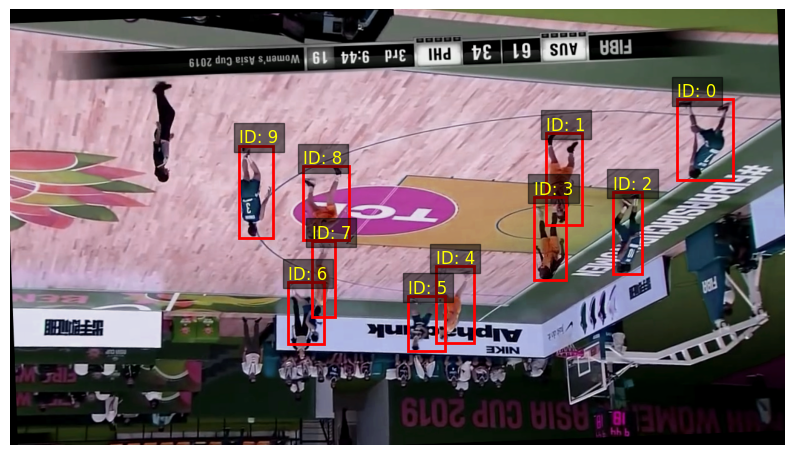


Train Sample 2 in Batch 1:
  Image shape: torch.Size([3, 720, 1280])
  Bounding boxes count: 10
  Player IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


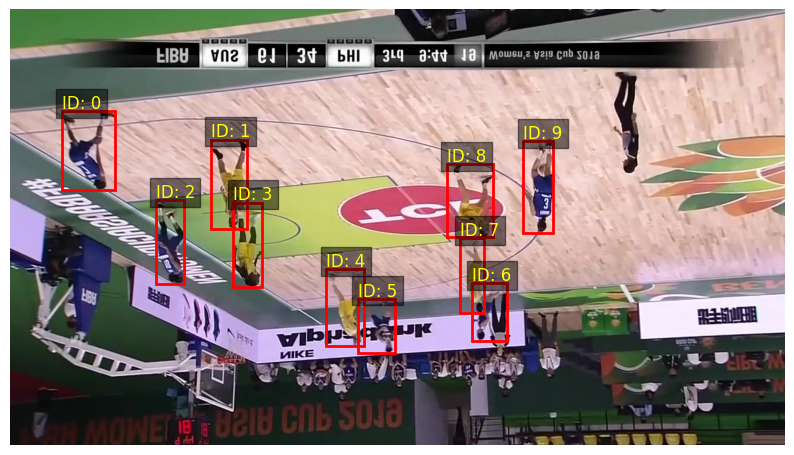


Visualizing samples from the validation loader...

Validation Sample 1 in Batch 1:
  Image shape: torch.Size([3, 720, 1280])
  Bounding boxes count: 8
  Player IDs: [0, 1, 2, 3, 4, 5, 6, 7]


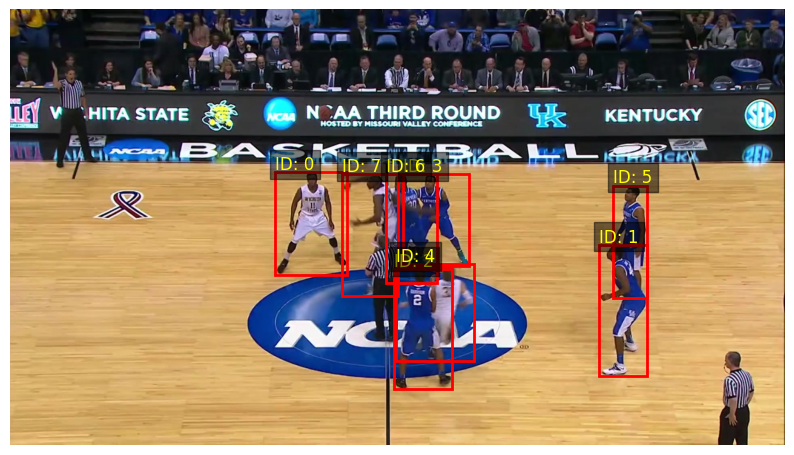


Validation Sample 2 in Batch 1:
  Image shape: torch.Size([3, 720, 1280])
  Bounding boxes count: 9
  Player IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8]


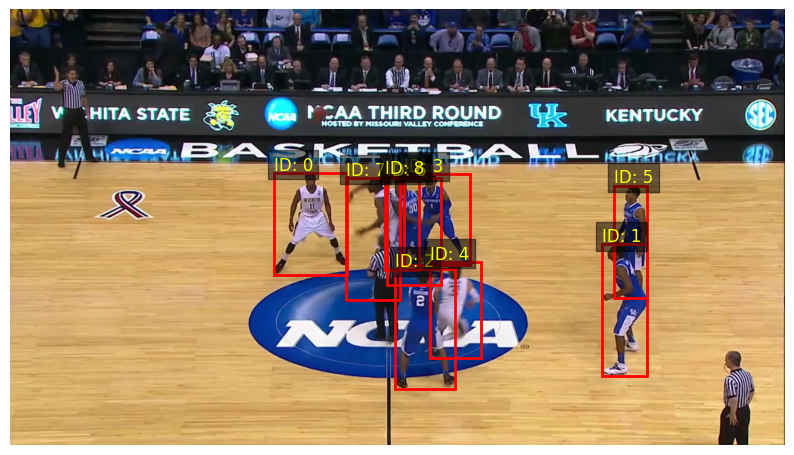

In [4]:
# Define the root directory of your dataset
ROOT = "/kaggle/input/sportsmot/sportsmot_publish"  # Replace with your actual path
    
# Define the directory containing split text files
SPLITS_TXT_DIR = os.path.join(ROOT, "splits_txt")
    
# Create dataloaders
train_dataset, val_dataset, train_loader, val_loader = get_dataloaders(
    data_root=os.path.join(ROOT, "dataset"),
    splits_txt_dir=SPLITS_TXT_DIR,
    batch_size=32,
    num_workers=4
)

# Test and visualize samples from the dataloaders
test_dataloaders(train_loader, val_loader, num_samples=1)


**train loader, val loader and test loader are prepared using Data Augmentation and and noise adding.**

# 2. Object Detection Algorithm Implementation

## 1- Introduce your chosen detection algorithm and explain the reasons for selecting it.

### Algorithm Selection: 

**YOLO**


### Reasons:

**1. Speed and Real-time Detection**

One of the key reasons I picked YOLO is its speed. YOLO processes images much faster compared to many other detection algorithms. It performs detection in a single pass, meaning it looks at the entire image and identifies objects in one go. This is crucial for real-time applications like video surveillance or autonomous driving, where quick detection is essential.

**2. Accuracy and Performance**

Although YOLO is fast, it doesn’t sacrifice accuracy. It achieves a great balance between speed and precision. The model is capable of detecting objects with high accuracy, even in complex scenes. For instance, it can handle overlapping objects, changes in size, and varying distances between the camera and the objects being detected. This makes it reliable in dynamic and busy environments.

**3. Unified Architecture**

YOLO uses a single neural network that simultaneously predicts the bounding boxes and class probabilities for objects. Many other models, like Faster R-CNN, break the detection process into two steps: first, proposing regions, and then classifying those regions. YOLO, on the other hand, does everything in one step. This unified approach is not only faster but also simpler to implement and deploy.

**4. Versatility**

YOLO is very versatile. It works well for a wide range of object detection tasks, from detecting pedestrians and vehicles in traffic to identifying various objects in images or videos. Whether it’s detecting one object or many, YOLO adapts easily to different applications.

**5. Open-Source and Active Community**

YOLO is open-source, meaning anyone can access and modify the code. This has led to a large community of developers and researchers who are continuously improving and updating the model. This level of community support is valuable because it ensures the algorithm stays up-to-date with new improvements, making it easier to implement the latest features and optimizations.

**6. Scalability**

YOLO is also scalable. Depending on the task, you can choose from different versions of YOLO that balance speed and accuracy. For example, a lighter version of YOLO, called Tiny YOLO, can run on devices with limited computational power (like mobile phones or embedded systems) while still performing object detection efficiently.

**7. Real-World Applications**

YOLO has been successfully used in various real-world applications, from robotics to security systems and even healthcare. Its proven success in diverse areas is another reason I chose it. Many companies and researchers use YOLO in production systems because it can handle high volumes of data and still deliver reliable results.

## 2- After preprocessing the data, train your model and provide the relevant Loss and Accuracy charts

**Converting the Dataset to YOLO Format**

Dataset structure required by YOLO is different than the structure of SportsMOT.

In this section, we transform our SportsMOT dataset into the format required for YOLO training.

In [29]:
# Define the output base directory for YOLO-formatted dataset
output_base = '/kaggle/working/YOLO_dataset'
splits = ['train', 'val']

# Create output folders for each split (images and labels)
for split in splits:
    os.makedirs(os.path.join(output_base, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_base, split, 'labels'), exist_ok=True)

def unnormalize_image(img_tensor):
    """
    Reverses normalization on an image tensor and converts it to a numpy array in [0,255].
    Assumes img_tensor is in shape (C, H, W) and normalized with the above mean and std.
    """
    # Move to CPU and convert to numpy array and unnormalize
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    img = (img * 255).astype(np.uint8)
    return img

def convert_bbox_to_yolo(box, img_width, img_height):
    """
    Converts a bounding box from Pascal VOC format [x_min, y_min, x_max, y_max]
    to YOLO format: normalized x_center, y_center, width, height.
    """
    x_min, y_min, x_max, y_max = box
    width = x_max - x_min
    height = y_max - y_min
    x_center = x_min + width / 2.0
    y_center = y_min + height / 2.0
    return (x_center / img_width, y_center / img_height,
            width / img_width, height / img_height)

def save_yolo_format(split, dataset):
    """
    Iterates over the provided dataset (train or val) and saves each sample
    in YOLO format. Images are saved as JPG files and labels are saved as text files.
    
    Args:
        split (str): 'train' or 'val'
        dataset (SportsMOTDataset): The dataset instance.
    """
    num_samples = len(dataset)
    print(f"Converting {num_samples} samples from the {split} split to YOLO format...")
    for idx in range(num_samples):
        # Get image and its corresponding target annotations
        image, targets = dataset[idx]
        
        # The image is expected to be a tensor (from ToTensorV2); unnormalize it.
        if isinstance(image, torch.Tensor):
            img_np = unnormalize_image(image)
        else:
            img_np = image  # if already a numpy array
        
        # Get image dimensions
        img_height, img_width = img_np.shape[:2]
        
        # Create a filename (using zero-padded index)
        filename = f"{idx:06d}.jpg"
        img_save_path = os.path.join(output_base, split, 'images', filename)
        
        # Check if the file already exists before saving (to avoid overwriting)
        if os.path.exists(img_save_path):
            print(f"Skipping existing file {img_save_path}")
            continue
        
        # Save image using cv2 (convert RGB to BGR as cv2 expects BGR)
        cv2.imwrite(img_save_path, cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR))
        
        # Create the corresponding YOLO label file
        label_save_path = os.path.join(output_base, split, 'labels', f"{idx:06d}.txt")
        
        # Check if the label file already exists before saving (to avoid overwriting)
        if os.path.exists(label_save_path):
            print(f"Skipping existing label {label_save_path}")
            continue
        
        with open(label_save_path, 'w') as f:
            boxes = targets['boxes']
            labels = targets['labels']
            # Convert tensors to numpy arrays if needed
            if isinstance(boxes, torch.Tensor):
                boxes = boxes.cpu().numpy()
            if isinstance(labels, torch.Tensor):
                labels = labels.cpu().numpy()
            
            # For each bounding box, convert from [x_min, y_min, x_max, y_max] to YOLO format
            for box, cls in zip(boxes, labels):
                x_center, y_center, width_norm, height_norm = convert_bbox_to_yolo(box, img_width, img_height)
                # Write annotation: <class> <x_center> <y_center> <width> <height>
                f.write(f"0 {x_center:.6f} {y_center:.6f} {width_norm:.6f} {height_norm:.6f}\n")
        
        if idx % 500 == 0 and idx > 0:
            print(f"Saved {idx} samples in the {split} split.")

    print(f"Finished converting {split} split to YOLO format.")

# Assuming train_dataset and val_dataset are already prepared (from your provided code)
# They have been augmented with noise, rotation, etc.

# Save YOLO format for both train and validation splits
save_yolo_format("train", train_dataset)
save_yolo_format("val", val_dataset)

print("Conversion complete. YOLO formatted datasets are saved in /kaggle/working/YOLO_dataset")


Converting 28574 samples from the train split to YOLO format...
Saved 500 samples in the train split.
Saved 1000 samples in the train split.
Saved 1500 samples in the train split.
Saved 2000 samples in the train split.
Saved 2500 samples in the train split.
Saved 3000 samples in the train split.
Saved 3500 samples in the train split.
Saved 4000 samples in the train split.
Saved 4500 samples in the train split.
Saved 5000 samples in the train split.
Saved 5500 samples in the train split.
Saved 6000 samples in the train split.
Saved 6500 samples in the train split.
Saved 7000 samples in the train split.
Saved 7500 samples in the train split.
Saved 8000 samples in the train split.
Saved 8500 samples in the train split.
Saved 9000 samples in the train split.
Saved 9500 samples in the train split.
Saved 10000 samples in the train split.
Saved 10500 samples in the train split.
Saved 11000 samples in the train split.
Saved 11500 samples in the train split.
Saved 12000 samples in the train spl

**Extracting number of unique classes in the dataset**

To train YOLO model we need to know how many unique classes we have in the dataset.

In [30]:
def extract_classes_from_annotations(data_root, split, video_names):
    """
    Extract unique class labels from annotation files (gt/gt.txt) for a given split.
    Args:
    
        data_root (str): Path to the root of the dataset.
        split (str): 'train', 'val', or 'test'.
        video_names (list): List of video directories for the given split.
    
    Returns:
        set: Set of unique class IDs.
    """
    classes = set()
    
    for video_name in video_names:
        gt_dir = os.path.join(data_root, split, video_name, 'gt')
        
        # Check for the existence of annotation files in the 'gt' directory
        if os.path.exists(gt_dir):
            for gt_file in os.listdir(gt_dir):
                if gt_file.endswith('.txt'):
                    gt_file_path = os.path.join(gt_dir, gt_file)
                    # Load annotations from file
                    try:
                        annotations = np.loadtxt(gt_file_path, delimiter=",", dtype=np.float32)
                        # Assuming class ID is in the 8th column (index 7), adjust if needed
                        class_ids = annotations[:, 7]  # Get the class IDs
                        classes.update(class_ids)  # Add class IDs to the set
                    except Exception as e:
                        print(f"Error reading {gt_file_path}: {e}")
        else:
            print(f"GT directory does not exist for video {video_name} in {split}.")
    
    return classes

def get_video_names(split_txt_path):
    """
    Get the list of video names from the split file.
    
    Args:
        split_txt_path (str): Path to the split txt file (train.txt, val.txt, test.txt).
    
    Returns:
        list: List of video names.
    """
    with open(split_txt_path, 'r') as f:
        video_names = [line.strip() for line in f.readlines() if line.strip()]
    return video_names

# Define the paths
data_root = '/kaggle/input/sportsmot/sportsmot_publish/dataset'  # Change this to your dataset path
splits_root = '/kaggle/input/sportsmot/sportsmot_publish'
splits_txt_dir = os.path.join(splits_root, 'splits_txt')

# Load the video names for the 'train' split (you can do the same for 'val' and 'test')
train_split_txt = os.path.join(splits_txt_dir, 'train.txt')
train_video_names = get_video_names(train_split_txt)

# Extract classes for the 'train' split
unique_classes = extract_classes_from_annotations(data_root, 'train', train_video_names)

print(f"Unique classes in train split: {unique_classes}")
print(f"Number of classes: {len(unique_classes)}")


Unique classes in train split: {1.0}
Number of classes: 1


**Creaing YAML file**

YOLO needs .yaml file for finding training data and validation data.

this file works as the config file.

In [2]:
import yaml
import os

# Paths for the YOLO dataset images and labels
output_base = '/kaggle/working/YOLO_dataset'
splits = ['train', 'val']

# Paths for images and labels for train and validation
train_img_dir = os.path.join(output_base, 'train', 'images')
train_label_dir = os.path.join(output_base, 'train', 'labels')
val_img_dir = os.path.join(output_base, 'val', 'images')
val_label_dir = os.path.join(output_base, 'val', 'labels')

# Class names (if you have more classes, you can add them here)
class_names = ['player']  # For example, if you are tracking "players" in sports videos

# Define the path for the YAML file
yaml_path = '/kaggle/working/YOLO_dataset/data.yaml'

# Create a dictionary with the YAML contents
yaml_data = {
    'train': train_img_dir,
    'val': val_img_dir,
    'nc': len(class_names),  # Number of classes
    'names': class_names,    # Class names
    'train_labels': train_label_dir,  # Path to training labels
    'val_labels': val_label_dir,      # Path to validation labels
}

# Save the dictionary to a YAML file
with open(yaml_path, 'w') as yaml_file:
    yaml.dump(yaml_data, yaml_file, default_flow_style=False)

print(f"YAML file created at {yaml_path}")


YAML file created at /kaggle/working/YOLO_dataset/data.yaml


**Training YOLO Model**

In [ ]:
model = YOLO("yolov8s.pt")


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'using device {device}')
# Start training
history = model.train(
    data='/kaggle/working/YOLO_dataset/data.yaml',    # Path to a custom yaml file with dataset config
    epochs=30,                                        # Number of epochs to train
    batch=32,                                         # Batch size (adjust based on your GPU memory)
    imgsz=640,                                        # Image size for training, YOLO expects imgsz instead of img_size
    val=True,                                         # Validate after each epoch
    workers=4,                                        # Number of workers for data loading
    device=device,                                    # Specify GPU to use (0 for the first GPU)
)

using device cuda
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/kaggle/working/YOLO_dataset/data.yaml, epochs=30, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=4, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=Fa

100%|██████████| 755k/755k [00:00<00:00, 26.1MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 107MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/YOLO_dataset/train/labels... 28574 images, 0 backgrounds, 0 corrupt: 100%|██████████| 28574/28574 [00:35<00:00, 798.17it/s] 


train: New cache created: /kaggle/working/YOLO_dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/YOLO_dataset/val/labels... 26970 images, 0 backgrounds, 0 corrupt: 100%|██████████| 26970/26970 [00:24<00:00, 1087.64it/s]

val: WARNING ⚠️ /kaggle/working/YOLO_dataset/val/images/015516.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/YOLO_dataset/val/images/015531.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/YOLO_dataset/val/images/015535.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/YOLO_dataset/val/images/015545.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/YOLO_dataset/val/images/015555.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/YOLO_dataset/val/images/015641.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/YOLO_dataset/val/images/015663.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/YOLO_dataset/val/images/015666.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/YOLO_dataset/val/images/015668.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/YOLO_dataset/val/images/021953.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/YOLO_dataset/val/i

val: New cache created: /kaggle/working/YOLO_dataset/val/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      8.08G      1.168     0.7633      1.031        583        640: 100%|██████████| 893/893 [08:22<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 422/422 [03:01<00:00,  2.32it/s]


                   all      26970     295473      0.942      0.941      0.964      0.752

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30       8.3G      1.019     0.5559     0.9565        557        640: 100%|██████████| 893/893 [08:18<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 422/422 [03:00<00:00,  2.34it/s]


                   all      26970     295473      0.943      0.941      0.959      0.765

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      8.29G      1.012     0.5471     0.9547        588        640: 100%|██████████| 893/893 [08:11<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 422/422 [02:54<00:00,  2.42it/s]


                   all      26970     295473      0.937      0.934      0.957      0.752

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      8.36G     0.9905     0.5307     0.9526        578        640: 100%|██████████| 893/893 [08:10<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 422/422 [02:45<00:00,  2.55it/s]


                   all      26970     295473      0.947      0.936      0.962      0.767

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      8.29G     0.9342     0.4943     0.9352        693        640: 100%|██████████| 893/893 [08:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 422/422 [02:44<00:00,  2.56it/s]


                   all      26970     295473      0.945      0.946      0.964      0.777

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      8.37G     0.8989     0.4713     0.9245        601        640: 100%|██████████| 893/893 [08:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 422/422 [02:43<00:00,  2.58it/s]


                   all      26970     295473      0.952      0.951       0.97      0.792

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      8.29G     0.8723     0.4539     0.9155        542        640: 100%|██████████| 893/893 [08:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 422/422 [02:43<00:00,  2.57it/s]


                   all      26970     295473      0.948       0.95      0.966      0.795

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      8.37G     0.8493     0.4403     0.9099        566        640: 100%|██████████| 893/893 [08:08<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 422/422 [02:45<00:00,  2.55it/s]


                   all      26970     295473       0.95      0.951      0.967      0.799

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      8.29G     0.8322     0.4293     0.9042        510        640: 100%|██████████| 893/893 [08:08<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 422/422 [02:45<00:00,  2.55it/s]


                   all      26970     295473      0.949      0.957      0.966      0.803

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      8.38G     0.8167       0.42     0.8993        733        640: 100%|██████████| 893/893 [08:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 422/422 [02:43<00:00,  2.58it/s]


                   all      26970     295473      0.952      0.953      0.966      0.803

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      8.29G     0.8039     0.4123     0.8964        608        640: 100%|██████████| 893/893 [08:08<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 422/422 [02:46<00:00,  2.53it/s]


                   all      26970     295473      0.954      0.954      0.971      0.813

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      8.37G     0.7949     0.4053     0.8932        645        640: 100%|██████████| 893/893 [08:09<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 422/422 [02:44<00:00,  2.56it/s]


                   all      26970     295473      0.955      0.954       0.97      0.811

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      8.29G     0.7831     0.3991     0.8899        603        640: 100%|██████████| 893/893 [08:06<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 422/422 [02:44<00:00,  2.57it/s]


                   all      26970     295473      0.953      0.958      0.966      0.814

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      8.37G     0.7774     0.3936     0.8872        644        640:  38%|███▊      | 342/893 [03:07<05:01,  1.83it/s]

**Load the Results CSV after training phase**

In [36]:
# Path to the results.csv file
results_csv_path = '/kaggle/working/runs/detect/train/results.csv'

# Load the CSV into a DataFrame
try:
    results_df = pd.read_csv(results_csv_path)
    print("Successfully loaded the results.csv file.")
except FileNotFoundError:
    print(f"File not found at {results_csv_path}. Please check the path and try again.")

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Successfully loaded the results.csv file.


**Inspect Results Structure**

In [37]:
# Display the first few rows of the DataFrame
print("First 5 rows of the results DataFrame:")
print(results_df.head())

# Display the DataFrame's columns
print("\nColumns in the DataFrame:")
print(results_df.columns.tolist())

# Get a summary of the DataFrame
print("\nDataFrame Summary:")
print(results_df.info())


First 5 rows of the results DataFrame:
   epoch      time  train/box_loss  train/cls_loss  train/dfl_loss  \
0      1   690.605         1.16823         0.76326         1.03057   
1      2  1373.240         1.01919         0.55588         0.95650   
2      3  2042.800         1.01183         0.54712         0.95470   
3      4  2704.490         0.99045         0.53067         0.95256   
4      5  3360.650         0.93420         0.49431         0.93520   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.94181            0.94096           0.96448   
1               0.94344            0.94133           0.95901   
2               0.93706            0.93396           0.95686   
3               0.94717            0.93640           0.96220   
4               0.94538            0.94567           0.96368   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
0              0.75210       0.83512       0.49778       0.90659  0.003330   

**Plot Training and Validation Loss**

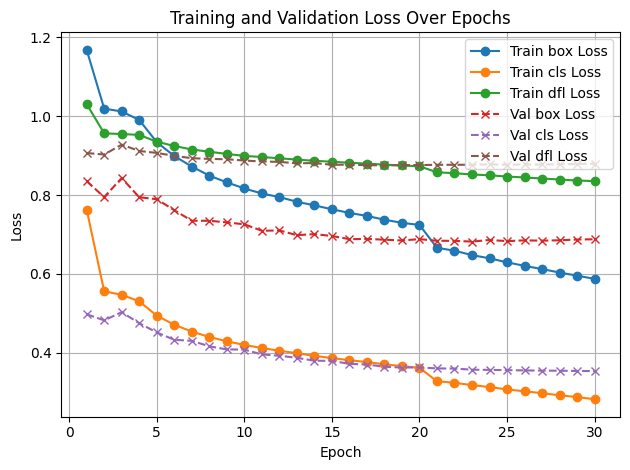

In [38]:
# Training Losses
plt.plot(results_df['epoch'], results_df['train/box_loss'], label='Train box Loss', marker='o', linestyle='-')
plt.plot(results_df['epoch'], results_df['train/cls_loss'], label='Train cls Loss', marker='o', linestyle='-')
plt.plot(results_df['epoch'], results_df['train/dfl_loss'], label='Train dfl Loss', marker='o', linestyle='-')

# Validation Losses
plt.plot(results_df['epoch'], results_df['val/box_loss'], label='Val box Loss', marker='x', linestyle='--')
plt.plot(results_df['epoch'], results_df['val/cls_loss'], label='Val cls Loss', marker='x', linestyle='--')
plt.plot(results_df['epoch'], results_df['val/dfl_loss'], label='Val dfl Loss', marker='x', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**We have no attribute as results yet, Of these, metrics/mAP50(B) and metrics/mAP50-95(B) are often considered the most relevant for object detection accuracy.**

In this section we see Class Accuracy is by far higher than Box Accuracy just as epxected.

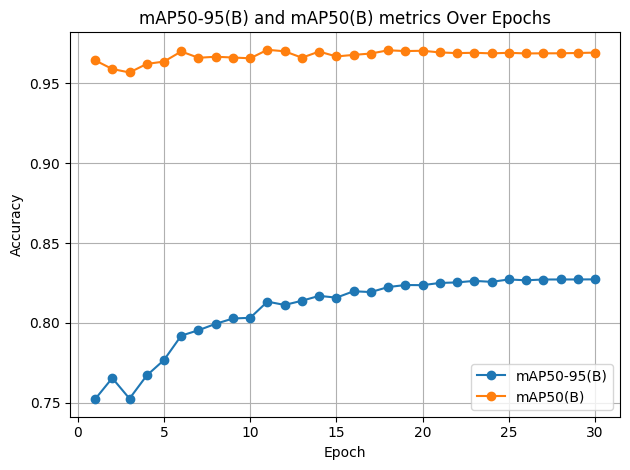

In [42]:
# Training Losses
plt.plot(results_df['epoch'], results_df['metrics/mAP50-95(B)'], label='mAP50-95(B)', marker='o', linestyle='-')
plt.plot(results_df['epoch'], results_df['metrics/mAP50(B)'], label='mAP50(B)', marker='o', linestyle='-')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('mAP50-95(B) and mAP50(B) metrics Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 3- Display the output of the detection model on several frames from the video and analyze whether the model has correctly identified objects (such as players and the ball) or not.

**Load the Trained YOLOv8 Model and Select Sample Validation Images**

In [14]:
model = YOLO('/kaggle/working/yolov8s.pt')
# Path to validation images
val_images_dir = '/kaggle/working/YOLO_dataset/val/images'

# List all image files in the validation images directory
image_files = [f for f in os.listdir(val_images_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Number of samples to visualize
num_samples = 5

# Select sample image files
sample_images = image_files[:num_samples]

print(f"Selected {len(sample_images)} sample images for visualization.")

Selected 5 sample images for visualization.


**Define Helper Functions**

In [15]:
def load_ground_truth_labels(label_path, image_size):
    """
    Load ground truth labels from a YOLO-formatted label file.

    Args:
        label_path (str): Path to the label file.
        image_size (tuple): (width, height) of the image.

    Returns:
        list of dicts: Each dict contains 'class_id' and 'bbox' in pixel coordinates.
    """
    if not os.path.exists(label_path):
        print(f"Label file {label_path} does not exist.")
        return []

    with open(label_path, 'r') as file:
        lines = file.readlines()

    ground_truths = []
    img_width, img_height = image_size

    for line in lines:
        parts = line.strip().split()
        if len(parts) != 5:
            continue  # Skip invalid lines
        class_id, x_center, y_center, width, height = map(float, parts)
        
        # Convert normalized coordinates to absolute pixels
        x_center *= img_width
        y_center *= img_height
        width *= img_width
        height *= img_height

        # Calculate top-left and bottom-right coordinates
        x1 = x_center - (width / 2)
        y1 = y_center - (height / 2)
        x2 = x_center + (width / 2)
        y2 = y_center + (height / 2)

        ground_truths.append({
            'class_id': int(class_id),
            'bbox': [x1, y1, x2, y2]
        })

    return ground_truths


def plot_image_with_boxes(image_path, ground_truths, predictions, class_names):
    """
    Plot an image with ground truth and predicted bounding boxes.

    Args:
        image_path (str): Path to the image file.
        ground_truths (list of dicts): Ground truth boxes with 'class_id' and 'bbox'.
        predictions (list of dicts): Predicted boxes with 'class_id', 'bbox', and 'confidence'.
        class_names (dict): Mapping from class IDs to class names.
    """
    # Open the image
    image = Image.open(image_path)
    img_width, img_height = image.size

    # Create a plot
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)
    ax.axis('off')  # Hide axes

    # Plot ground truth boxes in green
    for gt in ground_truths:
        class_id = gt['class_id']
        bbox = gt['bbox']
        x1, y1, x2, y2 = bbox
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='green', facecolor='none', label='Ground Truth')
        ax.add_patch(rect)
        ax.text(x1, y1 - 10, class_names[class_id], fontsize=12, color='green', backgroundcolor='none')  # Transparent background for text

    # Plot predicted boxes in red
    for pred in predictions:
        class_id = pred['class_id']
        bbox = pred['bbox']
        confidence = pred['confidence']
        x1, y1, x2, y2 = bbox
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='red', facecolor='none', label='Prediction')
        ax.add_patch(rect)
        ax.text(x1, y2 + 5, f"{class_names[class_id]} {confidence:.2f}", fontsize=12, color='red', backgroundcolor='none')  # Transparent background for text


    # Create custom legends
    handles = [
        patches.Patch(color='green', label='Ground Truth'),
        patches.Patch(color='red', label='Prediction')
    ]
    ax.legend(handles=handles, loc='upper right')

    plt.show()


**Run Predictions and Plot Results**

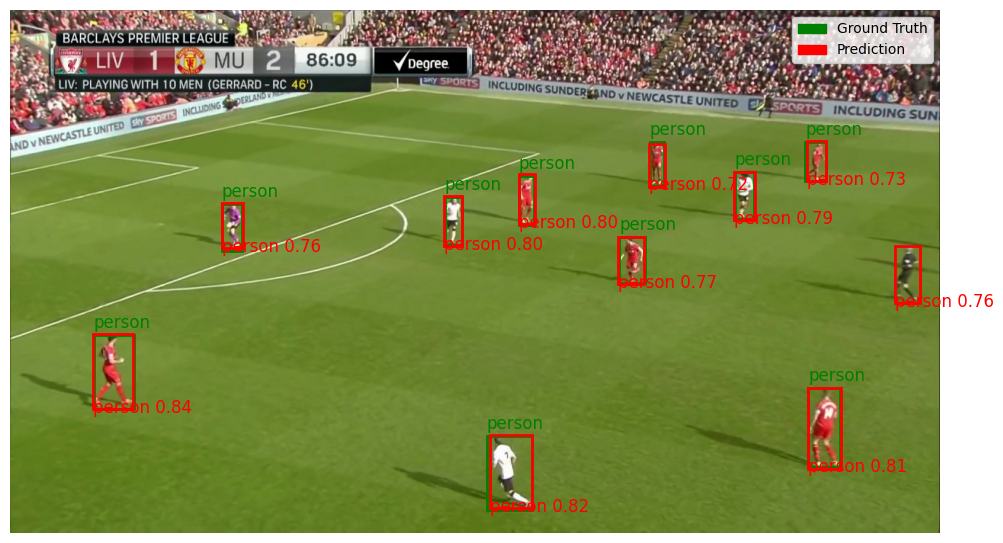

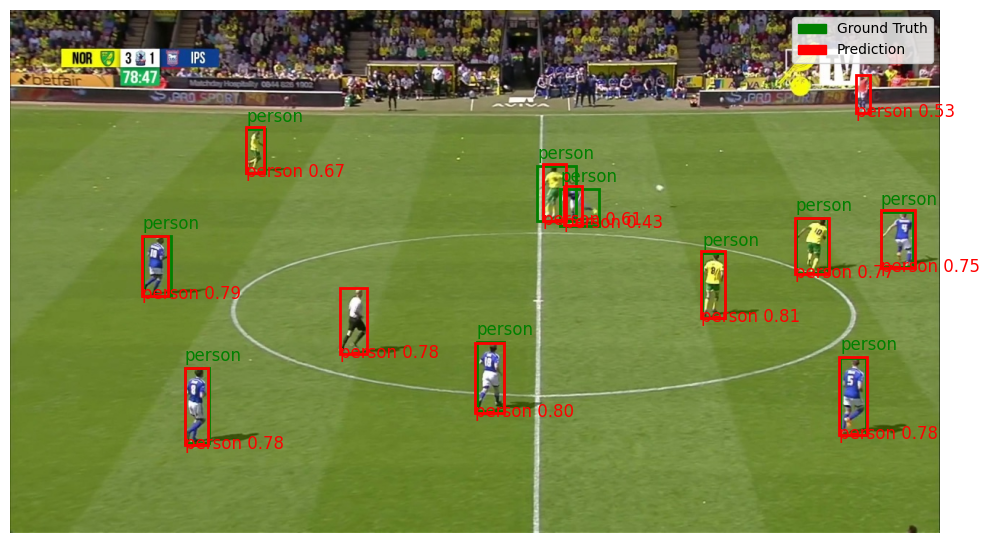

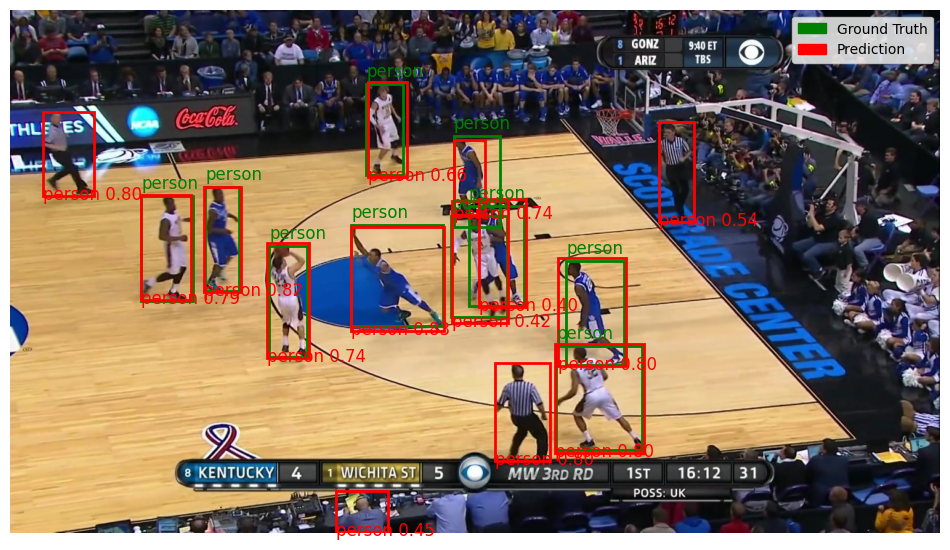

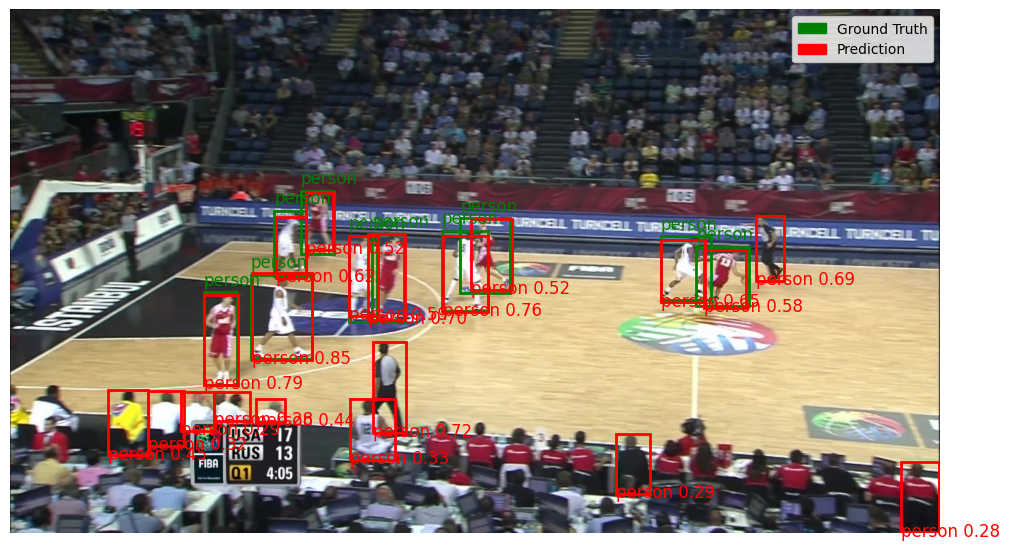

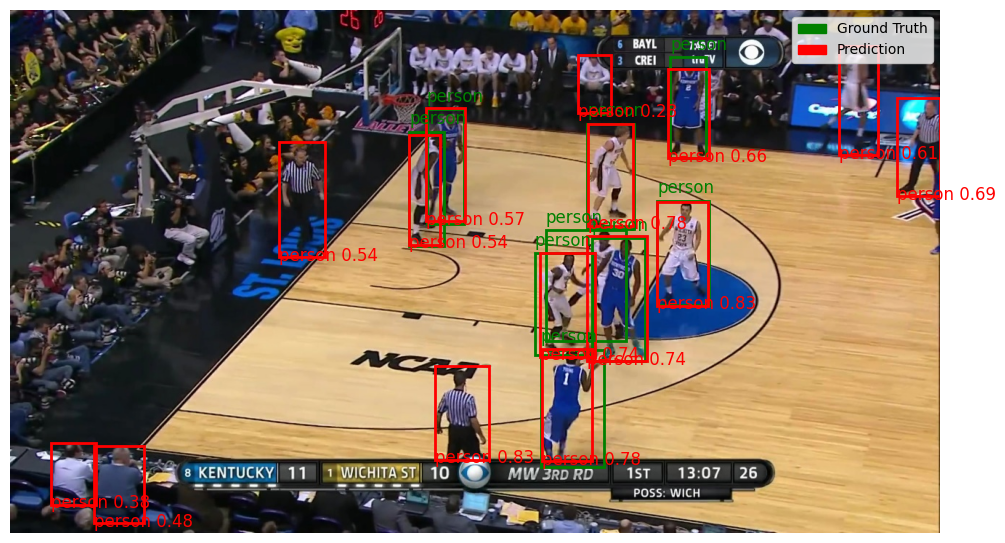

In [17]:
# Number of samples to visualize
num_samples = 5

# Iterate through each sample image
for img_file in sample_images:
    img_path = os.path.join(val_images_dir, img_file)
    
    # Run prediction
    # Setting verbose=False to suppress detailed output
    results = model.predict(source=img_path, verbose=False)
    
    # Extract predictions
    predictions = []
    for result in results:
        boxes = result.boxes
        for box in boxes:
            class_id = int(box.cls[0].item())
            confidence = box.conf[0].item()
            # Get bounding box coordinates
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            predictions.append({
                'class_id': class_id,
                'confidence': confidence,
                'bbox': [x1, y1, x2, y2]
            })
    
    # Load ground truth boxes
    # Assuming label files have the same base name as images but with .txt extension
    label_file = os.path.splitext(img_file)[0] + '.txt'
    label_path = os.path.join('/kaggle/working/YOLO_dataset/val/labels', label_file)
    
    # Get image size
    image = Image.open(img_path)
    img_width, img_height = image.size
    
    ground_truths = load_ground_truth_labels(label_path, (img_width, img_height))
    
    # Plot the image with boxes
    plot_image_with_boxes(
        image_path=img_path,
        ground_truths=ground_truths,
        predictions=predictions,
        class_names=model.names  # Assuming model.names is a dict {class_id: class_name}
    )


## 4- Evaluate the accuracy and performance of the model using various evaluation metrics.

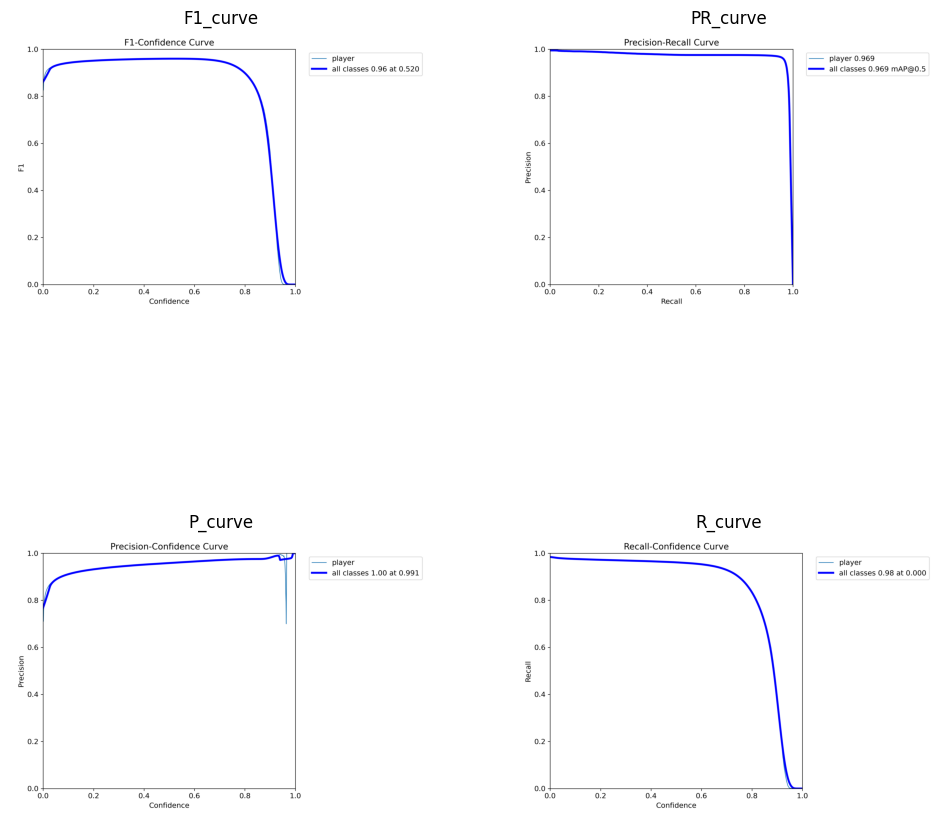

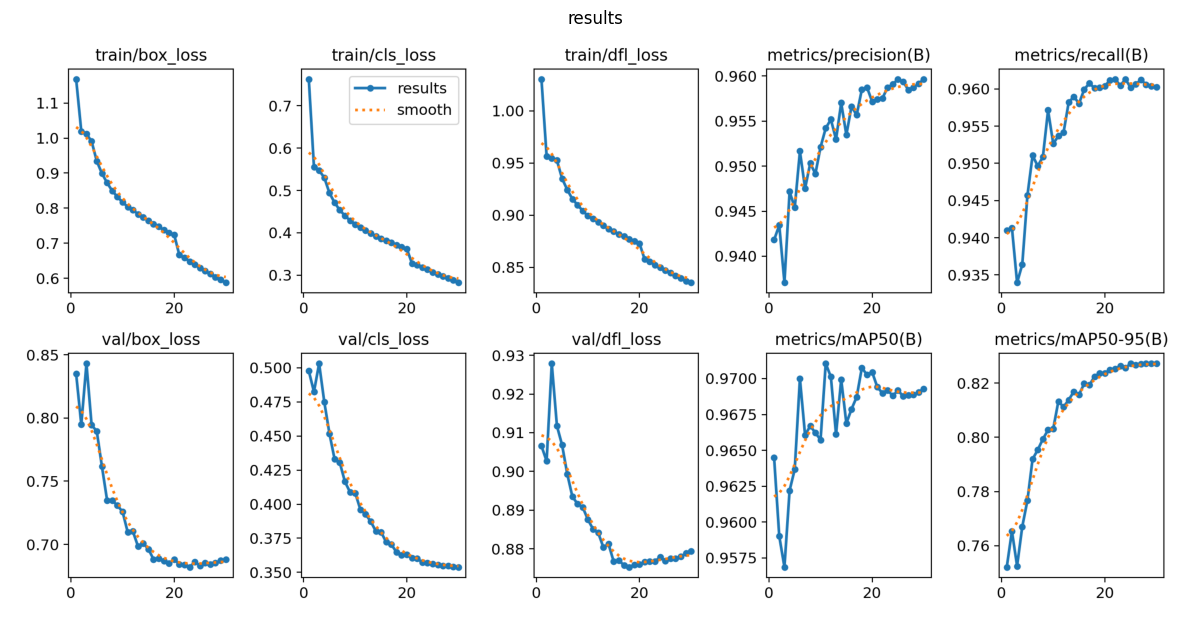

In [49]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Paths to the images
image_paths = [
    '/kaggle/working/runs/detect/train/F1_curve.png',
    '/kaggle/working/runs/detect/train/PR_curve.png',
    '/kaggle/working/runs/detect/train/P_curve.png',
    '/kaggle/working/runs/detect/train/R_curve.png',
    '/kaggle/working/runs/detect/train/results.png'
]

# Display the first four images in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()  # Flatten the 2x2 array of axes for easier iteration
for i in range(4):
    img = Image.open(image_paths[i])
    axes[i].imshow(img)
    # Use filename without extension as title
    axes[i].set_title(os.path.splitext(os.path.basename(image_paths[i]))[0])
    axes[i].axis('off')  # Hide axes

# Display the last image separately
fig2, ax2 = plt.subplots(figsize=(12, 12))
img2 = Image.open(image_paths[4])
ax2.imshow(img2)
ax2.set_title(os.path.splitext(os.path.basename(image_paths[4]))[0])
ax2.axis('off')

plt.tight_layout()
plt.show()


# 3. Single Object Tracking

## 1- Choose a single object tracking algorithm (such as CSRT Tracker or Siamese Networks) and explain the reasons for your selection

### Algorithm Selection

**CSRT Tracker**

### Reasons

**2. Robust to Occlusions**

One of the biggest challenges in object tracking is occlusion, where the object being tracked gets partially or fully hidden by other objects. CSRT is particularly robust to occlusions, meaning that it can maintain tracking even when the target is blocked for a short period. This is useful in applications where objects move behind obstacles or are temporarily hidden, such as in sports or surveillance footage.

**3. Adaptability to Scale Changes**

Another advantage of CSRT is its ability to adapt to scale variations. Objects can appear larger or smaller depending on their position relative to the camera, and CSRT adjusts the tracking model accordingly. This makes it effective for tracking objects in various settings, whether they are close to the camera or far away.

**4. Handles Illumination Changes**

Lighting conditions can change quickly in real-world scenarios, which can confuse simpler tracking algorithms. However, CSRT is less sensitive to illumination changes due to its use of channel and spatial reliability. This makes it effective even when the lighting shifts, such as when an object moves from a brightly lit area to a shadowed one.

**5. Computational Efficiency**

While being accurate and robust, CSRT is also relatively efficient in terms of computation. This means that it can run in real-time on many devices without requiring a lot of processing power. It’s a good choice for applications where you need to track objects continuously without overloading the system, like in robotics or surveillance systems.

**6. Proven Success in Various Applications**

CSRT has been widely tested and is known for its reliable performance in many real-world applications. It works well in tracking people, vehicles, or other moving objects in challenging conditions. Its proven success in these areas makes it a safe choice for practical use cases.

**7. Simple to Implement**

Finally, CSRT is easy to implement in most computer vision projects. It doesn't require complex setup or extensive fine-tuning, making it a great option for developers who need a robust solution quickly. It is also widely available in open-source libraries like OpenCV, which makes it easy to integrate into existing systems.

## 2- Implement the chosen algorithm and display the target object's path in a sample video

Generate a tracking video using the images.

To test CSRT Tracker implementation first we need a video.

In [21]:
import cv2
import os
import shutil
from glob import glob

# Set the image folder path and label folder path
image_folder = "/kaggle/working/YOLO_dataset/val/images"
label_folder = "/kaggle/working/YOLO_dataset/val/labels"  # Note: adjust if needed.
output_video = "/kaggle/working/input_video.mp4"

# Define the folder where the corresponding labels for the video will be saved
output_label_folder = "/kaggle/working/tracking_labels"
os.makedirs(output_label_folder, exist_ok=True)

# Get all image files sorted by filename (ensure sequential order)
image_files = sorted(glob(os.path.join(image_folder, "*.jpg")))

# Check if images exist
if not image_files:
    print("No images found in the directory!")
else:
    # Read the first image to get dimensions
    first_image = cv2.imread(image_files[0])
    height, width, layers = first_image.shape

    # Define the video codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 'mp4v' codec for MP4
    fps = 30  # Frames per second
    video = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

    # Process and add images to the video, while also saving corresponding label files.
    counter = 0
    for image_file in image_files:
        # Read the image
        img = cv2.imread(image_file)
        if img is None:
            print(f"Warning: Could not read {image_file}")
            continue

        # Write the frame to the video
        video.write(img)

        # -------------------------------
        # Save corresponding label file for later evaluation
        # -------------------------------
        # Assuming that the label file has the same basename with .txt extension.
        base_name = os.path.basename(image_file)
        label_filename = os.path.splitext(base_name)[0] + ".txt"
        # print(label_filename)
        label_path = os.path.join(label_folder, label_filename)
        # print(label_path)
        if os.path.exists(label_path):
            # Copy the label file to the output label folder.
            # Optionally, you can rename it to include the frame number (e.g., frame_0001.txt)
            new_label_filename = f"frame_{counter:06d}.txt"
            new_label_path = os.path.join(output_label_folder, new_label_filename)
            shutil.copy(label_path, new_label_path)
        else:
            # If there is no corresponding label file, you could create an empty file or log a warning.
            print(f"Warning: No label file for {base_name}")
            new_label_filename = f"frame_{counter:06d}.txt"
            new_label_path = os.path.join(output_label_folder, new_label_filename)
            with open(new_label_path, 'w') as f:
                f.write("")  # Write an empty label file

        # Optional: limit the number of processed frames for testing
        if counter > 600:
            break

        counter += 1

    # Release the video writer
    video.release()
    print(f"✅ Video saved at: {output_video}")
    print(f"✅ Corresponding labels saved at: {output_label_folder}")


✅ Video saved at: /kaggle/working/input_video.mp4
✅ Corresponding labels saved at: /kaggle/working/tracking_labels


Using device: cuda
Initial bounding box from YOLO: (219, 178, 58, 113)


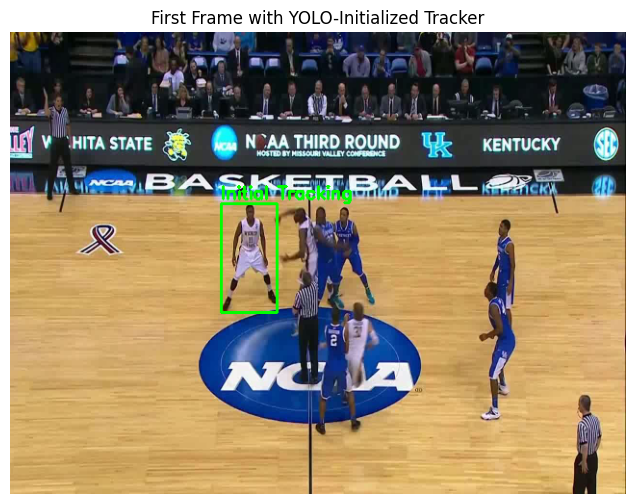

✅ Tracked video saved as: /kaggle/working/csrt_output_video.mp4


In [22]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import warnings
import random
from torchvision import transforms
from ultralytics import YOLO
from PIL import Image

warnings.filterwarnings("ignore")

# -------------------------
# YOLO Random Detection Function
# -------------------------
def YOLO_random_detection(frame, model, conf_threshold=0.7, target_cls=0):
    """
    Runs YOLO detection on the input frame and returns a detection box.
    The frame is assumed to be in BGR format.
    
    This function now resizes the frame to 640x480 (the same as our tracker input)
    rather than 640x640.
    
    Args:
        frame (numpy array): The input frame (BGR).
        model (torch model): The YOLO model (ultralytics YOLO), already loaded on the proper device.
        conf_threshold (float): Minimum confidence threshold.
        target_cls (int): The target class ID (e.g. 0 for person).
        
    Returns:
        tuple or None: Returns (x, y, width, height) for one detection that meets the threshold,
                       or None if no detection is found.
    """
    # Define transformation: convert BGR to RGB, resize to 640x480, then to tensor.
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((480, 640)),  # Note: PIL uses (height, width)
        transforms.ToTensor(),
    ])
    # Convert from BGR to RGB.
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    input_tensor = transform(rgb_frame).unsqueeze(0).to(next(model.parameters()).device)
    # Convert to half precision (assuming model is half)
    input_tensor = input_tensor.half()

    with torch.no_grad():
        results = model(input_tensor, verbose=False)
    # Assume results[0] is the detection output.
    yolo_result = results[0]
    if not hasattr(yolo_result, 'boxes') or len(yolo_result.boxes) == 0:
        print("YOLO: No detections found.")
        return None

    # Extract bounding boxes, confidences, and class IDs.
    boxes = yolo_result.boxes.xyxy.cpu().numpy()  # [x1, y1, x2, y2] in 640x480 space
    confs = yolo_result.boxes.conf.cpu().numpy()
    cls_ids = yolo_result.boxes.cls.cpu().numpy().astype(int)

    # Filter by confidence.
    mask = confs >= conf_threshold
    boxes = boxes[mask]
    confs = confs[mask]
    cls_ids = cls_ids[mask]

    # Filter by target class if specified.
    if target_cls is not None:
        mask_cls = (cls_ids == target_cls)
        boxes = boxes[mask_cls]
        confs = confs[mask_cls]
        cls_ids = cls_ids[mask_cls]

    if boxes.shape[0] == 0:
        print("YOLO: No detections passed threshold.")
        return None

    # Choose one detection – here we pick the one with highest confidence.
    best_index = np.argmax(confs)
    box = boxes[best_index]
    # Convert from [x1, y1, x2, y2] to (x, y, width, height)
    x1, y1, x2, y2 = box
    width = x2 - x1
    height = y2 - y1
    return (int(x1), int(y1), int(width), int(height))

# -------------------------
# CSRT Tracking Code with YOLO-based Initialization & Re-Initialization
# -------------------------
VIDEO_PATH = "/kaggle/working/input_video.mp4"
GT_LABEL_FOLDER = "/kaggle/working/tracking_labels"

# Open the video
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    print("Error: Cannot open video.")
    cap.release()
    exit()

# Read the first frame
ret, first_frame = cap.read()
if not ret:
    print("Error: Cannot read video.")
    cap.release()
    exit()

# Resize first frame to 640x480 (tracker input)
frame_resized = cv2.resize(first_frame, (640, 480))

# -------------------------
# Load YOLO model for detection (used for initialization and re-initialization)
# -------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
yolo_model = YOLO("/kaggle/working/yolov8s.pt").to(device)
yolo_model.eval()

# -------------------------
# Use YOLO to obtain a random detection to initialize the tracker.
# -------------------------
initial_bbox = YOLO_random_detection(first_frame, yolo_model, conf_threshold=0.7, target_cls=0)
if initial_bbox is None:
    print("No valid detection found in the first frame. Exiting.")
    cap.release()
    exit()
print(f"Initial bounding box from YOLO: {initial_bbox}")

# Initialize CSRT tracker with the YOLO detection.
tracker = cv2.TrackerCSRT_create()
tracker.init(frame_resized, initial_bbox)

# For visual check: draw initial bounding box on first frame.
init_frame_display = frame_resized.copy()
x, y, w, h = initial_bbox
cv2.rectangle(init_frame_display, (x, y), (x+w, y+h), (0, 255, 0), 2)
cv2.putText(init_frame_display, "Initial Tracking", (x, y-5),
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
plt.figure(figsize=(8,6))
plt.imshow(cv2.cvtColor(init_frame_display, cv2.COLOR_BGR2RGB))
plt.title("First Frame with YOLO-Initialized Tracker")
plt.axis("off")
plt.show()

# -------------------------
# Set up video writer and (optional) heatmap accumulation.
# -------------------------
OUTPUT_VIDEO_PATH = "/kaggle/working/csrt_output_video.mp4"
frame_width_output = 1280  # desired output resolution width
frame_height_output = 720  # desired output resolution height
fps = cap.get(cv2.CAP_PROP_FPS)
if fps == 0:
    fps = 30
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(OUTPUT_VIDEO_PATH, fourcc, fps, (frame_width_output, frame_height_output))

# (Optional) Create a heatmap accumulation array for tracking (in 640x480 resolution)
heatmap_accum = np.zeros((480, 640), dtype=np.float32)

frame_counter = 0
ious = []
precisions = []
recalls = []
f1_scores = []

def parse_gt_file(gt_file, img_width, img_height):
    """
    Parse a ground truth label file in YOLO normalized format:
      class x_center y_center width height.
    Converts to (x, y, x2, y2) in pixel coordinates.
    """
    gt_boxes = []
    if os.path.exists(gt_file):
        with open(gt_file, 'r') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                parts = line.split()
                x_center = float(parts[1])
                y_center = float(parts[2])
                w_norm = float(parts[3])
                h_norm = float(parts[4])
                abs_x_center = x_center * img_width
                abs_y_center = y_center * img_height
                abs_w = w_norm * img_width
                abs_h = h_norm * img_height
                x = int(abs_x_center - abs_w / 2)
                y = int(abs_y_center - abs_h / 2)
                gt_boxes.append((x, y, x + int(abs_w), y + int(abs_h)))
    return gt_boxes

# -------------------------
# Tracking Loop with YOLO-based Re-Initialization
# -------------------------
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Resize frame to 640x480 for tracking
    frame_resized = cv2.resize(frame, (640, 480))
    
    # Update tracker (CSRT runs on CPU)
    success, bbox_pred = tracker.update(frame_resized)
    
    if success:
        x, y, w, h = map(int, bbox_pred)
    else:
        # If tracking is lost, use YOLO to find a new object.
        print(f"Frame {frame_counter}: Tracker lost. Reinitializing via YOLO.")
        new_box = YOLO_random_detection(frame, yolo_model, conf_threshold=0.7, target_cls=0)
        if new_box is not None:
            x, y, w, h = new_box
            # Reinitialize the tracker with the new box.
            tracker = cv2.TrackerCSRT_create()
            tracker.init(frame_resized, new_box)
            print(f"Reinitialized tracker with box: {new_box}")
        else:
            print(f"Frame {frame_counter}: YOLO did not find a new object. Skipping frame.")
            frame_counter += 1
            continue

    # Draw tracked box on the frame.
    cv2.rectangle(frame_resized, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.putText(frame_resized, "Tracking", (x, y-5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    # Update heatmap: increment the region of the tracked box.
    x_end = min(x+w, heatmap_accum.shape[1])
    y_end = min(y+h, heatmap_accum.shape[0])
    heatmap_accum[y:y_end, x:x_end] += 1

    # --- Evaluation: Use closest ground truth box ---
    gt_file = os.path.join(GT_LABEL_FOLDER, f"frame_{frame_counter:06d}.txt")
    gt_boxes = parse_gt_file(gt_file, 640, 480)
    if gt_boxes:
        tracked_center = (x + w/2, y + h/2)
        best_gt = None
        min_distance = float('inf')
        for gt in gt_boxes:
            gt_x, gt_y, gt_x2, gt_y2 = gt
            gt_center = ((gt_x + gt_x2)/2, (gt_y + gt_y2)/2)
            distance = np.sqrt((tracked_center[0] - gt_center[0])**2 +
                               (tracked_center[1] - gt_center[1])**2)
            if distance < min_distance:
                min_distance = distance
                best_gt = gt
        if best_gt is not None:
            gt_x, gt_y, gt_x2, gt_y2 = best_gt
            # cv2.rectangle(frame_resized, (gt_x, gt_y), (gt_x2, gt_y2), (255, 0, 0), 2)
            # cv2.putText(frame_resized, "GT", (gt_x, gt_y-5),
            #             cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
            xi1 = max(x, gt_x)
            yi1 = max(y, gt_y)
            xi2 = min(x+w, gt_x2)
            yi2 = min(y+h, gt_y2)
            inter_width = max(0, xi2 - xi1)
            inter_height = max(0, yi2 - yi1)
            intersection = inter_width * inter_height
            union = (w * h) + ((gt_x2 - gt_x) * (gt_y2 - gt_y)) - intersection
            iou = intersection / union if union > 0 else 0
            ious.append(iou)
            precision = 1 if iou > 0.5 else 0
            recall = 1 if iou > 0.5 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            precisions.append(precision)
            recalls.append(recall)
            f1_scores.append(f1)
    else:
        cv2.putText(frame_resized, "No GT", (50, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

    # Resize frame for output video (1280x720) and write it.
    frame_resized_output = cv2.resize(frame_resized, (1280, 720))
    out.write(frame_resized_output)
    frame_counter += 1

cap.release()
out.release()
cv2.destroyAllWindows()

print(f"✅ Tracked video saved as: {OUTPUT_VIDEO_PATH}")


## 3- Common challenges in single object tracking, such as occlusion, scale variation, and illumination change, should be reviewed.

**1. Occlusion**

Occlusion occurs when the object being tracked is temporarily hidden by other objects or obstacles in the scene. This can happen in various situations, such as when the object moves behind a larger object, or when people or other objects pass in front of the target. The main challenge here is that the tracker loses visual information and has to either predict where the object will reappear or rely on the object's motion patterns to recover.

Occlusion is particularly difficult because the tracker might not be able to see any part of the object for a while, making it hard to maintain accurate tracking. If the tracker doesn't have a good recovery mechanism (e.g., by predicting motion based on past frames or using context clues), it can easily drift away or lose track of the object. Advanced tracking algorithms, like CSRT, try to address this by updating the appearance model of the object continuously and by considering previous frame information to predict the object's location after occlusion.

**2. Scale Variation**

Scale variation refers to changes in the size of the object due to its movement towards or away from the camera, or because of changes in perspective. In many real-world scenarios, objects may appear larger or smaller depending on their relative position to the camera, and the tracker must be able to adjust accordingly.

This challenge is problematic because traditional tracking methods often assume that the size of the object remains constant over time. If the object changes size significantly, the tracker may either lose track of it (if it becomes too small) or start tracking the wrong part of the image (if it becomes too large). Modern tracking algorithms like CSRT address this by adjusting the correlation filter's size dynamically, allowing the tracker to maintain accurate tracking even with significant scale changes.

**3. Illumination Change**

Illumination change refers to changes in lighting conditions, such as when the object moves from a well-lit area into shadow, or when the light source changes (e.g., during sunset or under artificial lighting). Lighting plays a crucial role in how an object appears in an image, and significant changes can make the object’s visual features difficult for the tracker to recognize.

For instance, under bright light, colors and edges are more distinguishable, but in low-light situations or when there's backlighting, the object might appear darker or with fewer distinct features. This makes it hard for the tracker to rely on color or intensity-based features. To handle illumination changes, some trackers use methods that focus on local features (which are less dependent on lighting) or employ algorithms that normalize or adapt to lighting conditions. CSRT, for example, uses both channel reliability and spatial reliability, which helps it remain robust under varying lighting conditions.

## 4- Evaluate the accuracy of the algorithm using various metrics.

In [24]:
avg_iou = np.mean(ious)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1_score = np.mean(f1_scores)

print(f"Average IoU: {avg_iou:.2f}")
print(f"Average Precision: {avg_precision:.2f}")
print(f"Average Recall: {avg_recall:.2f}")
print(f"Average F1 Score: {avg_f1_score:.2f}")

Average IoU: 0.56
Average Precision: 0.61
Average Recall: 0.61
Average F1 Score: 0.61


## 5- Analyze in which conditions the algorithm performs better and in which conditions it encounters errors.

### CSRT performs well when:

The target has distinct appearance and a stable, uncluttered background.
Motion is slow to moderate with minimal motion blur.
Occlusions are brief or partial.
Illumination and viewpoint remain relatively constant.

### CSRT struggles when:

The target moves very fast or erratically (causing motion blur).
Occlusions are severe or prolonged, especially with similar objects nearby.
The target undergoes dramatic scale changes or non-rigid deformations.
The scene is cluttered or lighting conditions change abruptly.

## 6- Display a heatmap of the tracked motion. In fact, this output is designed to show, using colors, the extent of the target's presence in different areas.

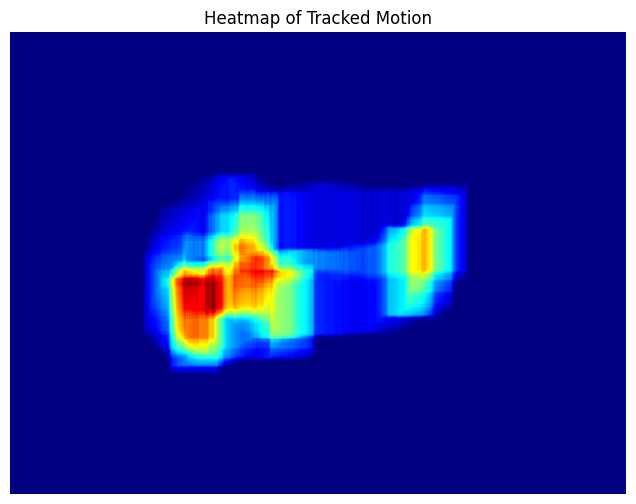

In [26]:
# -------------------------
# Heatmap Visualization
# -------------------------
# If heatmap_accum is already a NumPy array, we use it directly.
# (If it were a torch tensor, you would convert it using .cpu().numpy())
heatmap_norm = cv2.normalize(heatmap_accum, None, 0, 255, cv2.NORM_MINMAX)
heatmap_norm = heatmap_norm.astype(np.uint8)

# Apply a colormap (using the JET colormap)
heatmap_colored = cv2.applyColorMap(heatmap_norm, cv2.COLORMAP_JET)

plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB))
plt.title("Heatmap of Tracked Motion")
plt.axis("off")
plt.show()


# 4.  Multiple Object Tracking

## 
1- Choose a multi-object tracking algorithm and explain why this algorithm is suitable for this scenario.

### Algorithm Selection:

**ByteTrack**


### Reasons

**1. Effective Detection Association**

ByteTrack uses both high-confidence and low-confidence detection boxes. This helps in keeping track of objects even when some detections are not very clear. It smartly combines all the available information, ensuring that objects are not lost during occlusion or fast movements.

**2. Robust in Crowded Scenes**

In scenes where many objects are close together or overlap, traditional trackers might mix up the identities. ByteTrack, however, is designed to handle such crowded scenes well. It accurately links the right detections across frames, which means it can keep track of each object even when they move close to each other.

**3. High Performance and Speed**

The algorithm is built to work fast. This is crucial for applications like video surveillance or autonomous driving, where real-time tracking is needed. ByteTrack processes the data quickly while still maintaining good tracking accuracy.

**4. Simplicity and Ease of Use**

Despite its advanced performance, ByteTrack is relatively simple to implement. This makes it a practical choice for projects where you need a reliable tracker without an overly complex setup.

**5. Adaptability**

ByteTrack is flexible and can handle a variety of conditions—whether it’s changes in lighting, object scale, or partial occlusions. This adaptability means it can be used in different environments without needing major adjustments.

## 2- Explain the relationship between detection and tracking algorithms. How is the output of detection converted into the input for the tracking algorithm?

**1. Detection Finds the Objects**

The detection algorithm scans each frame of the video and identifies objects, usually by drawing boxes (bounding boxes) around them. For example, a detection model might look at a frame and say, "There is a person here, and here is another person over there."

**2. Output of Detection**

The output from the detection algorithm is a list of objects with their bounding boxes, class labels (what type of object they are), and sometimes confidence scores that show how sure the model is about each detection.

**3. Tracking Uses These Detections**

The tracking algorithm takes the list of detected objects from each frame and links the same objects across different frames. This helps in understanding the movement and behavior of each object over time. Essentially, tracking is about assigning a unique ID to each detected object and keeping that ID consistent as the object moves.

Converting Detection Output into Tracking Input:

**Bounding Boxes:** The bounding boxes from the detection are used as the starting point for tracking. The tracker uses these boxes to know where each object is located in the current frame.
Confidence Scores and Labels: Sometimes, the tracker uses the confidence scores or the type of object (like "person" or "car") to decide how to match detections in one frame with detections in the next frame.
Association Process: Tracking algorithms often compare the current frame's detected bounding boxes with those from the previous frame. They use measures such as overlap (Intersection over Union, IoU) or appearance features to decide which box in the current frame belongs to which object from the previous frame.
Why This Relationship Matters:

**Efficiency:** By using detections as input, the tracker doesn't have to search the whole frame for objects; it just focuses on the areas highlighted by the detector.
Accuracy Over Time: Even if the detection algorithm misses an object in one frame or two, the tracker can often still follow the object based on its motion and appearance from previous frames.
Handling New Objects: When a new object enters the scene, the detection algorithm finds it, and then the tracking algorithm assigns it a new ID, starting a new tracking path.

## 3- Explain the assignment process in your algorithm. What mechanism, such as the Hungarian Algorithm, is used to match objects in consecutive frames? Explain.

**1. Collecting Detections**

In every frame, the detection algorithm finds objects and provides their locations (usually in the form of bounding boxes).

**2. Comparing Frames**

To track objects, we need to match the objects from the current frame with those from the previous frame. The idea is to figure out which detection in the current frame corresponds to which object we saw before.

**3. Creating a Cost Matrix**
For each object from the previous frame and each detection in the current frame, we calculate a “cost” that shows how different or similar they are. This cost might be based on the distance between their positions, the overlap of their bounding boxes (using a measure like Intersection over Union), or even their appearance.

**4. Using the Hungarian Algorithm**

The Hungarian Algorithm is a method used to find the best way to match objects from the previous frame to the current frame so that the overall cost is minimized. In other words, it finds the assignment where each detection is paired with the most likely previous object, while keeping the total “difference” as low as possible.

**5. Assigning IDs**

Once the best matches are found, the algorithm assigns the same unique identifier (ID) to the matched objects. This way, the tracker knows that, for example, the object in the current frame with ID 3 is the same as the one that was detected as ID 3 in the previous frames.

**6. Handling New or Lost Objects**

If there is a detection in the current frame that doesn’t match any previous object well (the cost is too high), it might be treated as a new object and assigned a new ID. Similarly, if an object from the previous frame is not matched with any current detection, it might be considered as lost.

## 4- Implement the algorithm and display the tracking results in a video.

### MOT Using ByteTrack Algorithm

Assume train_loader and val_loader are prepared from last sections.

helper functions

In [27]:
import sys
sys.path.append('/kaggle/working/ByteTrack')
from utils import util
from nets import nn
import os
import sys
import cv2
import torch
import numpy as np
import warnings
import motmetrics as mm
from glob import glob
import base64
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from PIL import Image

def draw_line(image, x1, y1, x2, y2, index):
    """Draw bounding box with corner lines and ID text."""
    w = 10
    h = 10
    color = (200, 0, 0)
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 200, 0), 2)
    cv2.line(image, (x1, y1), (x1 + w, y1), color, 3)
    cv2.line(image, (x1, y1), (x1, y1 + h), color, 3)
    cv2.line(image, (x2, y1), (x2 - w, y1), color, 3)
    cv2.line(image, (x2, y1), (x2, y1 + h), color, 3)
    cv2.line(image, (x2, y2), (x2 - w, y2), color, 3)
    cv2.line(image, (x2, y2), (x2, y2 - h), color, 3)
    cv2.line(image, (x1, y2), (x1 + w, y2), color, 3)
    cv2.line(image, (x1, y2), (x1, y2 - h), color, 3)
    text = f'ID:{str(index)}'
    cv2.putText(image, text, (x1, y1 - 2),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0),
                thickness=1, lineType=cv2.LINE_AA)


def compute_iou_matrix(gt_boxes, pred_boxes):
    """
    Compute the IoU matrix between two sets of boxes.
    Both inputs are NumPy arrays of shape (N, 4) and (M, 4) in (x1,y1,x2,y2) format.
    Returns an array of shape (N, M).
    """
    gt_boxes = gt_boxes.astype(np.float32)
    pred_boxes = pred_boxes.astype(np.float32)
    xA = np.maximum(gt_boxes[:, None, 0], pred_boxes[None, :, 0])
    yA = np.maximum(gt_boxes[:, None, 1], pred_boxes[None, :, 1])
    xB = np.minimum(gt_boxes[:, None, 2], pred_boxes[None, :, 2])
    yB = np.minimum(gt_boxes[:, None, 3], pred_boxes[None, :, 3])
    interW = np.maximum(0, xB - xA)
    interH = np.maximum(0, yB - yA)
    interArea = interW * interH
    gt_area = (gt_boxes[:, 2] - gt_boxes[:, 0]) * (gt_boxes[:, 3] - gt_boxes[:, 1])
    pred_area = (pred_boxes[:, 2] - pred_boxes[:, 0]) * (pred_boxes[:, 3] - pred_boxes[:, 1])
    unionArea = gt_area[:, None] + pred_area[None, :] - interArea
    iou = interArea / (unionArea + 1e-6)
    return iou


def parse_gt_file(gt_file, img_width, img_height):
    """
    Parse a ground truth label file. Each line is assumed to be in YOLO format:
      class x_center y_center width height (all normalized).
    Converts to (x, y, x2, y2) pixel coordinates.
    """
    gt_boxes = []
    if os.path.exists(gt_file):
        with open(gt_file, 'r') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                parts = line.split()
                x_center = float(parts[1])
                y_center = float(parts[2])
                w_norm   = float(parts[3])
                h_norm   = float(parts[4])
                abs_x_center = x_center * img_width
                abs_y_center = y_center * img_height
                abs_w = w_norm * img_width
                abs_h = h_norm * img_height
                x = int(abs_x_center - abs_w / 2)
                y = int(abs_y_center - abs_h / 2)
                gt_boxes.append((x, y, x + int(abs_w), y + int(abs_h)))
    return gt_boxes


def preload_video_frames(video_path):
    """Pre-load all frames from the video into a list."""
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return frames


def preload_gt_files(gt_folder):
    """
    Preload ground truth file paths into a dictionary mapping frame index to file path.
    Assumes file names like: frame_000000.txt, frame_000001.txt, etc.
    """
    gt_files = {}
    for file in sorted(glob(os.path.join(gt_folder, "*.txt"))):
        basename = os.path.basename(file)
        frame_num = int(basename.split('_')[1].split('.')[0])
        gt_files[frame_num] = file
    return gt_files


def preprocess_frame(frame, size):
    """
    Resize and process a single frame to the input size.
    Returns the preprocessed image and scaling info (original shape and pad info).
    """
    image = frame.copy()
    orig_shape = image.shape[:2]
    r = size / max(orig_shape)
    if r != 1:
        h, w = orig_shape
        image = cv2.resize(image, (int(w * r), int(h * r)), interpolation=cv2.INTER_LINEAR)
    h, w = image.shape[:2]
    image_resized, ratio, pad = util.resize(image, size)
    return image_resized, orig_shape, ((h / orig_shape[0], w / orig_shape[1]), pad)


In [48]:
# Clear cached memory and optimize PyTorch performance
torch.cuda.empty_cache()
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False

warnings.filterwarnings("ignore")


def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    size = 640

    # Load YOLOv8 model
    model_path = '/kaggle/working/yolov8s.pt'
    if not os.path.exists(model_path):
        print(f"Error: Model file does not exist at {model_path}")
        return
    model = torch.load(model_path, map_location=device)['model'].float()
    model.to(device)
    model.eval()
    model.half()

    input_video_path = '/kaggle/working/input_video.mp4'
    if not os.path.exists(input_video_path):
        print(f"Error: Input video file does not exist at {input_video_path}")
        return

    # Pre-load all frames from the video
    frames = preload_video_frames(input_video_path)
    if len(frames) == 0:
        print("No frames loaded!")
        return

    # Get video properties from the first frame
    frame_height, frame_width = frames[0].shape[:2]
    fps = 30  # (or extract from VideoCapture if desired)

    # Pre-load ground truth files (mapping frame index to file path)
    GT_LABEL_FOLDER = "/kaggle/working/tracking_labels"
    gt_files_dict = preload_gt_files(GT_LABEL_FOLDER)

    bytetrack = nn.BYTETracker(fps)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    output_video_path = '/kaggle/working/ByteTrack_output_video.mp4'
    writer = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

    acc = mm.MOTAccumulator(auto_id=True)
    sample_frame = None

    # Process all pre-loaded frames from memory.
    for frame_count, frame in enumerate(frames):
        boxes = []
        confidences = []
        object_classes = []

        image = frame.copy()
        shape = image.shape[:2]
        r = size / max(shape[0], shape[1])
        if r != 1:
            h, w = shape
            image = cv2.resize(image, (int(w * r), int(h * r)), interpolation=cv2.INTER_LINEAR)
        h, w = image.shape[:2]
        image, ratio, pad = util.resize(image, size)
        shapes = shape, ((h / shape[0], w / shape[1]), pad)
        sample_np = image.transpose((2, 0, 1))[::-1]
        sample_np = np.ascontiguousarray(sample_np)
        sample_tensor = torch.unsqueeze(torch.from_numpy(sample_np), dim=0)
        sample_tensor = sample_tensor.to(device).half() / 255.0

        with torch.no_grad():
            outputs = model(sample_tensor)[0]
        outputs = util.non_max_suppression(outputs, 0.001, 0.5)
        # Use this vectorized version:
        for i, output in enumerate(outputs):
            # Clone and scale all detection boxes at once for this batch sample.
            detections = output.clone()
            # 'util.scale' is assumed to operate in place on detections[:, :4]
            util.scale(detections[:, :4], sample_tensor[i].shape[1:], shapes[0], shapes[1])
            # Convert the entire tensor to NumPy at once.
            det_np = detections.cpu().numpy()
            # Convert all bounding box coordinates to integers in one go.
            boxes_i = det_np[:, :4].astype(int)
            # Extend the global lists with the vectorized results.
            boxes.extend(boxes_i.tolist())
            confidences.extend(det_np[:, 4].tolist())
            object_classes.extend(det_np[:, 5].tolist())

        outputs = bytetrack.update(np.array(boxes), np.array(confidences), np.array(object_classes))
        pred_boxes = []
        pred_ids = []
        if len(outputs) > 0:
            boxes_out = outputs[:, :4]
            identities = outputs[:, 4]
            object_classes_out = outputs[:, 6]
            for i, box in enumerate(boxes_out):
                if object_classes_out[i] != 0:  # Only process person class
                    continue
                x1, y1, x2, y2 = list(map(int, box))
                pred_boxes.append((x1, y1, x2, y2))
                pred_ids.append(int(identities[i]))
                draw_line(frame, x1, y1, x2, y2, int(identities[i]))

        writer.write(frame)
        if frame_count == 0:
            sample_frame = frame.copy()

        # --- Evaluation for current frame ---
        gt_file = gt_files_dict.get(frame_count, None)
        gt_boxes = []
        if gt_file is not None:
            gt_boxes = parse_gt_file(gt_file, frame_width, frame_height)
        gt_ids = list(range(len(gt_boxes)))
        if len(gt_boxes) > 0 and len(pred_boxes) > 0:
            gt_arr = np.array(gt_boxes)
            pred_arr = np.array(pred_boxes)
            iou_matrix = compute_iou_matrix(gt_arr, pred_arr)
            cost_matrix = 1 - iou_matrix
        else:
            cost_matrix = np.empty((len(gt_boxes), len(pred_boxes)), dtype=np.float32)
        gt_ids_arr = np.array(gt_ids, dtype=float)
        pred_ids_arr = np.array(pred_ids, dtype=float)
        acc.update(gt_ids_arr, pred_ids_arr, cost_matrix)
        # print(frame_count)

    writer.release()

    mh = mm.metrics.create()
    summary = mh.compute(acc, metrics=['precision', 'idf1', 'mota'], name='Overall')
    print(f"✅ Tracked video saved as: {output_video_path}")
    return summary


if __name__ == "__main__":
    summary = main()


✅ Tracked video saved as: /kaggle/working/ByteTrack_output_video.mp4


## 5- Evaluate the algorithm's performance using metrics such as Precision, IDF1, and MOTA (Multiple Object Tracking Accuracy).

We see the model has proper and acceptable performance based on the results below.

In [49]:
print("Evaluation Summary:")
print(summary)

Evaluation Summary:
         precision      idf1      mota
Overall    0.83557  0.615266  0.781408


## 6- Analyze and evaluate common challenges such as Switch, Occlusion, and Illumination Change.

**1. Switch (Identity Switch)**

In multi-object tracking, a "switch" happens when the tracker accidentally swaps the identities of two objects. For example, when two people come close or cross paths, ByteTrack might sometimes mix up their IDs. Even though ByteTrack is designed to handle multiple objects well, crowded scenes or overlapping paths can still lead to identity switches. This challenge makes it difficult to follow each individual over time because the algorithm might not always know which detection belongs to which person.

**2. Occlusion**

Occlusion occurs when an object is partly or completely hidden behind another object. Imagine a person walking behind a bus or another person; the tracker can't see them for a moment. In ByteTrack, if an object is occluded, the algorithm uses past information and motion patterns to predict where that object might be when it reappears. However, if the occlusion is too long or if there are many similar objects around, the tracker might lose track or mix up identities. This is a common challenge in busy scenes where objects frequently block each other.

**3. Illumination Change**

Illumination changes refer to variations in lighting conditions—such as shadows, bright sunlight, or indoor lighting—that alter how an object looks from one frame to the next. These changes can affect the features the algorithm uses to recognize and match objects over time. Even though ByteTrack uses a robust approach to detection and matching, sudden or dramatic changes in lighting can make it harder for the tracker to consistently identify objects, leading to potential mistakes or missed detections.

### MOT Using DeepSORT Algorithm 

In [3]:
!pip install deep-sort-realtime
!pip install ultralytics
# !git clone https://github.com/KaiyangZhou/deep-person-reid.git
# !cd /kaggle/working/deep-person-reid/
# !python /kaggle/working/deep-person-reid/setup.py develop

In [52]:
# Set random seed for reproducibility
np.random.seed(67)

# Set up device (force CUDA if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load YOLOv8 model (ensure it's moved to CUDA)
model_path = '/kaggle/working/yolov8s.pt'
if not os.path.exists(model_path):
    raise FileNotFoundError(f"YOLOv8 model not found at {model_path}")

model = YOLO(model_path).to(device)
model.eval()

# Initialize DeepSORT tracker and move it to CUDA
deepsort = DeepSort(
    max_cosine_distance=0.2,
    nn_budget=100,
    max_iou_distance=0.7,
    max_age=30,
    n_init=3,
    nms_max_overlap=1.0
)

# Load video
VIDEO_PATH = '/kaggle/working/input_video.mp4'
cap = cv2.VideoCapture(VIDEO_PATH)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_fps = int(cap.get(cv2.CAP_PROP_FPS))

# Output video writer
out = cv2.VideoWriter(
    "/kaggle/working/DeepSORT_output_video.mp4",
    cv2.VideoWriter_fourcc(*'mp4v'), frame_fps,
    (frame_width, frame_height)
)

frame_count = 0  # Track number of frames processed

def convert_detections(yolo_results, conf_threshold=0.5, target_cls=None):
    """
    Convert YOLOv8 detections to a DeepSORT-compatible format on CUDA.
    """
    if not hasattr(yolo_results, 'boxes') or len(yolo_results.boxes) == 0:
        return torch.empty((0, 5), dtype=torch.float32).to(device)

    boxes = yolo_results.boxes
    xyxy = boxes.xyxy.to(device)  # Move to CUDA
    conf = boxes.conf.to(device)
    cls_ids = boxes.cls.to(device)

    mask = conf >= conf_threshold
    xyxy = xyxy[mask]
    conf = conf[mask]
    cls_ids = cls_ids[mask]

    if target_cls is not None:
        mask_cls = (cls_ids == target_cls)
        xyxy = xyxy[mask_cls]
        conf = conf[mask_cls]

    if xyxy.shape[0] == 0:
        return torch.empty((0, 5), dtype=torch.float32).to(device)

    return torch.cat((xyxy, conf.unsqueeze(1)), dim=1)  # Stack boxes & confidence

def draw_detections(image, yolo_result, conf_threshold=0.5):
    """
    Draw YOLOv8 detections on the image before passing it to DeepSORT.
    
    Args:
        image (numpy array): The OpenCV frame where detections will be drawn.
        yolo_result (YOLO result object): The raw YOLO output (results[0]).
        conf_threshold (float): Confidence threshold to filter low-confidence detections.
    """
    if not hasattr(yolo_result, 'boxes') or len(yolo_result.boxes) == 0:
        print("No detections found.")
        return

    # Extract bounding boxes, confidence scores, and class IDs
    boxes = yolo_result.boxes.xyxy.cpu().numpy()  # Get (x1, y1, x2, y2)
    confs = yolo_result.boxes.conf.cpu().numpy()  # Get confidence scores
    class_ids = yolo_result.boxes.cls.cpu().numpy().astype(int)  # Get class IDs
    
    for box, conf, class_id in zip(boxes, confs, class_ids):
        if conf < conf_threshold:
            continue  # Skip low-confidence detections

        x1, y1, x2, y2 = map(int, box)
        color = (0, 255, 0)  # Green for YOLO detections

        # Draw bounding box
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

        # Label with confidence score and class ID
        label = f"Class {class_id} ({conf:.2f})"
        cv2.putText(image, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)


while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    start_time = time.time()

    # Convert BGR to RGB (YOLO requires RGB input)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    rgb_frame_tensor = torch.tensor(rgb_frame, dtype=torch.float32).to(device)  # Move image to CUDA

    # Define YOLO preprocessing transform
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((640, 640)),  # Resize to YOLO-compatible size
        transforms.ToTensor(),  # Convert to (C, H, W)
    ])
    
    # Convert image to YOLO-compatible format
    rgb_frame_tensor = transform(rgb_frame).unsqueeze(0).to(device)  # Add batch dimension

    # Run YOLO inference on GPU
    with torch.no_grad():
        results = model(rgb_frame_tensor, verbose=False)

    # Convert YOLO detections to DeepSORT format
    detections = convert_detections(results[0], conf_threshold=0.5)

    # Debugging: Draw YOLO detections before tracking
    draw_detections(frame, results[0])

    # Convert detections to DeepSORT format
    detections_list = []
    for row in detections.cpu().numpy():  # Move to CPU for compatibility
        bbox = row[:4].tolist()
        conf_val = float(row[4])
        detections_list.append((bbox, conf_val))

    # Run DeepSORT tracking on GPU
    tracks = deepsort.update_tracks(detections_list, frame=frame)

    # Draw tracking results
    for track in tracks:
        if not track.is_confirmed():
            continue
        track_id = track.track_id
        x1, y1, x2, y2 = map(int, track.to_ltrb())
        cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue for tracked objects
        text = f'ID: {track_id}'
        cv2.putText(frame, text, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Write processed frame to output video
    out.write(frame)

    frame_count += 1
    # print(f"Processed frame {frame_count}, FPS: {1 / (time.time() - start_time):.2f}")

    # Optional: Stop early for debugging

# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()

print(f"✅ Tracked video saved as: {output_video_path}")

Using device: cuda
✅ Tracked video saved as: /kaggle/working/DeepSORT_output_video.mp4


# 5. Improving the algorithm and presenting a proposed method

## 1- Research

### 1. Propose at least one improvement method for your tracking algorithm. To do this, you can select one of the common challenges in object tracking and suggest an enhancement method to address this challenge. Explain the details and steps of the algorithm thoroughly.

One improvement method I would propose is adding a re-identification (ReID) module to the ByteTrack tracking algorithm. This enhancement is especially useful for addressing the challenge of identity switches, which often occur when objects (like people) overlap or move close to each other.

*How Does This Help?*

**Reduced Identity Switches:**

When two objects come close, the original tracker might confuse their identities. With a ReID module, the system has additional information (appearance features) to decide which object is which.

**Handling Occlusion Better**

If an object is temporarily blocked (occluded), the tracker can use the appearance features from the ReID module to match the object when it reappears.

*Steps to Integrate a ReID Module into ByteTrack*

**Feature Extraction**

For every detection (each bounding box of a person), pass the cropped image region through a pre-trained ReID network. This network outputs a feature vector—a list of numbers—that uniquely represents the appearance of that object.

**Store Appearance Features**

Along with the usual spatial information (bounding box coordinates, motion history, etc.), store the feature vector for each tracked object in a database or memory.

**Matching New Detections**

When a new frame comes in, the tracker receives new detections. For each detection:

Run the ReID network to extract its feature vector.
Compare this vector with the stored feature vectors of previously tracked objects.
Use a similarity measure (like cosine similarity) to determine which stored vector (and therefore which object) is most similar to the new detection.
Update the Tracker:
Combine the appearance similarity score with the usual spatial information (like the Intersection over Union or motion prediction). This combined score makes the matching process more robust. It helps the tracker decide the best match for each object in the new frame, reducing the chance of mixing up IDs.

**Maintain and Refresh**

Over time, update the stored feature vector for each object with the most recent appearance data. This helps in case the object's appearance changes (for example, if lighting conditions change or the person turns around).

Detailed Steps in Simple Words:
Step 1: When an object is detected, cut out that part of the image and run it through a small neural network (the ReID module) to get a list of numbers that describe it.
Step 2: Save these numbers together with the object's location and ID.
Step 3: In the next frame, when new objects are detected, do the same thing and compare the new numbers with the saved ones.
Step 4: If the new numbers are very similar to the saved ones, it means it is likely the same object. Use this match to update the object’s ID.
Step 5: Keep updating these features as new frames come in so that the tracker always has the latest appearance information.
Conclusion
By integrating a ReID module, ByteTrack can become more robust against identity switches and occlusions. This simple addition helps the tracker recognize objects based on how they look, not just where they are, leading to more stable and accurate tracking in complex scenes.

This method enhances the algorithm by using both spatial (position, movement) and appearance (how an object looks) information, which makes tracking more reliable even under challenging conditions.


### 2. Conduct a general study on optimization models for model transformation and their presentation as a product. Explain why optimizing models is essential for their transformation into a product. Describe different categories of methods, along with the advantages and disadvantages of each, in detail.

*Categories of Optimization Methods*

Optimization methods can be broadly categorized into a few main groups. Each has its advantages and disadvantages.

1. Exact Methods
Description:
Exact methods aim to find the best possible solution by exploring all possible options, often using mathematical programming techniques such as linear programming (LP), mixed-integer programming (MIP), or convex optimization.

Advantages:

Optimality: They guarantee that the solution is the best one according to the defined criteria.
Theoretical Foundation: These methods are built on strong mathematical theory, ensuring reliability in many cases.
Disadvantages:

Scalability: They often require a lot of computational power, making them impractical for very large models.
Complexity: As the model size grows, the time required to find the optimal solution can increase dramatically.
2. Heuristic Methods
Description:
Heuristic methods use rules or shortcuts to find good enough solutions quickly without searching every possible option. Examples include greedy algorithms and local search techniques.

Advantages:

Speed: They usually find a solution very quickly, which is useful when time is limited.
Simplicity: Heuristics are often easier to implement and understand.
Disadvantages:

No Guarantee of Optimality: The solution found might not be the best possible one.
Problem Specific: Many heuristics are designed for a specific type of problem and may not work well on others without significant changes.
3. Metaheuristic Methods
Description:
Metaheuristics are higher-level frameworks designed to guide other heuristics to search for near-optimal solutions in complex, large-scale problems. Examples include Genetic Algorithms, Simulated Annealing, Particle Swarm Optimization, and Ant Colony Optimization.

Advantages:

Flexibility: They can be applied to a wide range of problems.
Robustness: Metaheuristics are good at avoiding local optima, often finding a better overall solution.
Scalability: They tend to handle larger problems better than exact methods.
Disadvantages:

Computational Cost: While not as expensive as exact methods, metaheuristics can still require significant computational resources, especially for very large or complex models.
Parameter Sensitivity: Their performance often depends on careful tuning of parameters, which can be time-consuming.
No Guarantee of Optimality: Like heuristics, they generally do not guarantee that the solution is the absolute best one, only that it is near-optimal.
4. Hybrid Methods
Description:
Hybrid methods combine elements of exact, heuristic, and metaheuristic approaches. They try to balance the benefits of each method to overcome their individual limitations. For example, one might use a metaheuristic to find a good starting point and then refine the solution using an exact method.

Advantages:

Balanced Performance: They can provide near-optimal solutions in a reasonable time frame.
Adaptability: By combining approaches, they can be more flexible and robust against different types of problems.
Disadvantages:

Complexity in Implementation: Hybrid methods can be more difficult to design and implement because they involve integrating different algorithms.
Tuning Required: They often require careful calibration to get the best results from each component of the method.